# **TENSORFLOW FEDEREATED LEARNING**

In [ ]:
'''
python version = 3.6
'''

'\npython version = 3.6\n'

In [ ]:
# importing necessary libraries
import os 
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

import collections
import numpy as np

from matplotlib import pyplot as plt

import tensorflow as tf 
from tensorflow.keras.datasets import mnist
from tensorflow.keras import losses, metrics, optimizers, Sequential
from tensorflow import reshape, nest, config
import tensorflow_federated as tff

from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from pathlib import Path

import cv2
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix
from mlxtend.plotting import plot_confusion_matrix


from sklearn import preprocessing
le = preprocessing.LabelEncoder()

In [ ]:
import nest_asyncio
nest_asyncio.apply()

In [ ]:
%load_ext tensorboard

In [ ]:
def plot_graph(X, y, format = '-', label=''):
    """function for plotting graph

    Args:
        X (list): list of epochs number 
        y (list): list of accuray values in each epochs 
        format (str, optional): _description_. Defaults to '-'.
        label (str, optional): label of figure. Defaults to ''.
    """

    plt.plot(X, y, format, label=label)
    plt.xlabel("Epoch")
    plt.ylabel("Value")
    plt.grid(True)

In [ ]:
size = 96

In [ ]:
# creating model with keras 
def create_keras_model():
    """ function for creating Convolutional Neural Network architecture 

    Returns:
        tf.Sequential: neural network model architecture
    """
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(size, size, 1)),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(3, activation='softmax')
    ])
    return model

In [ ]:
model = create_keras_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 94, 94, 32)        320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 47, 47, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 22, 22, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 30976)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               15860224  
_________________________________________________________________
dense_5 (Dense)              (None, 3)                

In [ ]:
# setting environment to use GPU if available
gpus = config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [ ]:
# setting up parameter values used during our experiment
client_lr = 1e-2
server_lr = 1
client_number = 5
NUM_ROUNDS = 20
NUM_EPOCHS = 10
BATCH_SIZE = 10
PREFETCH_BUFFER = 5

In [ ]:
model_dir = Path.cwd()/"models"
output_dir = Path.cwd()/"results"

In [ ]:
if not model_dir.exists():
    model_dir.mkdir(parents=True)

if not output_dir.exists():
    output_dir.mkdir(parents=True)

##  **Covid-19 : Federated Learning using tensorflow-federated and normal ML algorithm**

### Starting with the information, Federated learning generally requires a federated data set, or a collection of data from different users. Because federated data is frequently non-i.i.d., it presents a special set of difficulties.

In [ ]:
train_path = 'Covid19-dataset/train'
test_path = 'Covid19-dataset/test'

To get a sense of the examples on one simulated device, let's first take a sample of data from one client.

In [ ]:
# preparing train data 
x_train_covid = []
y_train_covid = []
for folder in os.listdir(train_path):
    img_path = f'{train_path}/{folder}'

    for img in os.listdir(img_path):
        img_arr = cv2.imread(f'{img_path}/{img}', 0)
        img_arr = cv2.resize(img_arr, (size,size))
        x_train_covid.append(img_arr)
        y_train_covid.append(folder)

In [ ]:
# label encoding and random shuffling for training dataset
le.fit(y_train_covid)
y_train_covid = le.transform(y_train_covid)
x_train_covid, y_train_covid = shuffle(x_train_covid, y_train_covid)

In [ ]:
y_train_covid

array([2, 2, 0, 2, 0, 2, 0, 0, 1, 0, 0, 0, 0, 1, 2, 0, 0, 0, 2, 0, 0, 1,
       2, 0, 2, 2, 0, 0, 0, 0, 0, 1, 2, 0, 0, 1, 2, 2, 1, 0, 0, 0, 2, 1,
       2, 0, 1, 0, 1, 0, 0, 0, 1, 0, 2, 0, 2, 0, 2, 0, 2, 1, 0, 2, 1, 2,
       2, 1, 2, 0, 0, 0, 1, 0, 0, 1, 2, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1,
       2, 0, 1, 1, 2, 2, 1, 2, 1, 1, 2, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0,
       2, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 1, 0, 0, 2,
       1, 0, 2, 0, 1, 0, 0, 2, 0, 1, 2, 2, 2, 1, 1, 0, 2, 2, 2, 2, 1, 0,
       0, 2, 1, 0, 2, 1, 2, 2, 1, 1, 0, 0, 0, 2, 0, 1, 2, 2, 0, 2, 0, 1,
       2, 2, 0, 0, 1, 2, 2, 1, 1, 2, 1, 2, 0, 1, 1, 2, 0, 2, 1, 1, 0, 1,
       1, 2, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       2, 0, 2, 0, 0, 1, 2, 1, 1, 1, 0, 2, 0, 2, 1, 1, 0, 0, 2, 0, 0, 1,
       2, 2, 2, 0, 1, 1, 0, 2, 2])

In [ ]:
# preparing test data
x_test_covid = []
y_test_covid = []
for folder in os.listdir(test_path):
    img_path = f'{test_path}/{folder}'

    for img in os.listdir(img_path):
        img_arr = cv2.imread(f'{img_path}/{img}', 0)
        img_arr = cv2.resize(img_arr, (size,size))
        x_test_covid.append(img_arr)
        y_test_covid.append(folder)

In [ ]:
# label encoding and shuffling validation dataset
le.fit(y_test_covid)
y_test_covid = le.transform(y_test_covid)
x_test_covid, y_test_covid = shuffle(x_test_covid, y_test_covid)

In [ ]:
# converting to numpy array
x_train_covid = np.asarray(x_train_covid).astype(np.float32)
x_train_covid = x_train_covid.reshape(len(x_train_covid), size, size, 1)
x_test_covid = np.asarray(x_test_covid).astype(np.float32)
x_test_covid = x_test_covid.reshape(len(x_test_covid), size, size, 1)

y_train_covid = np.asarray(y_train_covid).astype(np.int32)
y_test_covid = np.asarray(y_test_covid).astype(np.int32)
y_test_covid = y_test_covid.reshape(len(y_test_covid), 1)

In [ ]:
print(x_train_covid.shape, x_test_covid.shape)

(251, 96, 96, 1) (66, 96, 96, 1)


In [ ]:
total_image_count = len(x_train_covid)
image_per_set = int(np.floor(total_image_count/client_number))

In [ ]:
print(image_per_set)

50


## Different dataset Distribution
### For the purpose of our experiment, we used three scnenarios:
<li>Even Data Distribution</li>
<li>UnEven Data Distribution</li>
<li>Custom Data Distribution (Removing Data from certain client)</li>

#### with these scenarios, we intend to observe the model evaluation: FedAvg algorithms performance on various scenario. For evenly distribution case, we divided dataset to each client in equal numbers, for uneven case we divided dataset randomly and number of datasets to clients differ with each other. For custom distribution case, we removed Viral Pneunomia datasets from one of the clients. All the datasets with their respective configuration is trained using normal and federated machine learning algorithms




## #1 Even Data Distribution

In [ ]:
# generating arrays for random data distribution 
uneven_dist = np.random.dirichlet(np.ones(client_number), size=1)[0]
uneven_dist

array([0.08406876, 0.57681817, 0.01617231, 0.09711959, 0.22582117])

In [ ]:
# preparing client train datasets : Evenly Distributed
client_train_dataset_even = collections.OrderedDict()

print("preparing evenly distributed data")
for i in range(1, client_number+1):
    client_name = "client_" + str(i)
    start = image_per_set * (i-1)
    end = image_per_set * (i)

    print(f"Adding data from {start} to {end} for client : {client_name}")
    data = collections.OrderedDict((('label', y_train_covid[start:end]), ('pixels', x_train_covid[start:end])))
    client_train_dataset_even[client_name] = data

preparing evenly distributed data
Adding data from 0 to 50 for client : client_1
Adding data from 50 to 100 for client : client_2
Adding data from 100 to 150 for client : client_3
Adding data from 150 to 200 for client : client_4
Adding data from 200 to 250 for client : client_5


In [ ]:
print("preparing unevenly distributed data")
client_train_dataset_uneven = collections.OrderedDict()

us = 0
for i in range(1, client_number+1):
    client_name = "client_" + str(i)

    uneven_start = us
    uneven_end = int(total_image_count*uneven_dist[i-1])
    us = us + uneven_end
    uneven_end = uneven_start + uneven_end
    
    if i == client_number:
        uneven_end = total_image_count
    
    print(f"Adding data from {uneven_start} to {uneven_end} for client : {client_name}")
    uneven_data = collections.OrderedDict((('label', y_train_covid[uneven_start:uneven_end]), ('pixels', x_train_covid[uneven_start:uneven_end])))
    client_train_dataset_uneven[client_name] = uneven_data

preparing unevenly distributed data
Adding data from 0 to 21 for client : client_1
Adding data from 21 to 165 for client : client_2
Adding data from 165 to 169 for client : client_3
Adding data from 169 to 193 for client : client_4
Adding data from 193 to 251 for client : client_5


In [ ]:
# preparing dataset distribution by vanishing some data from 
data_1 = None
client_train_dataset_1 = client_train_dataset_even.copy()
for c in client_train_dataset_1:
    if c == 'client_1':
        covid_index = np.where(client_train_dataset_1[c]['label'] == 2)
        for ci in covid_index:
            la = np.delete(client_train_dataset_1[c]['label'],ci)
            lv = np.delete(client_train_dataset_1[c]['pixels'], ci, axis=0)
        
        data_1 = collections.OrderedDict((('label', la), ('pixels', lv)))
del client_train_dataset_1['client_1']
client_train_dataset_1.update({'client_1': data_1})

In [ ]:
client_train_dataset_1['client_1']

OrderedDict([('label',
              array([0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
                     1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0], dtype=int32)),
             ('pixels',
              array([[[[  2.],
                       [  1.],
                       [  0.],
                       ...,
                       [196.],
                       [190.],
                       [188.]],
              
                      [[  0.],
                       [  0.],
                       [  0.],
                       ...,
                       [212.],
                       [211.],
                       [219.]],
              
                      [[  0.],
                       [  0.],
                       [  0.],
                       ...,
                       [213.],
                       [214.],
                       [216.]],
              
                      ...,
              
                      [[  0.],
                       [

In [ ]:
# preparing simulation dataset for client
client_train_dataset_even =  tff.simulation.FromTensorSlicesClientData(client_train_dataset_even)

In [ ]:
sample_dataset_even = client_train_dataset_even.create_tf_dataset_for_client(client_train_dataset_even.client_ids[0])
sample_element_even = next(iter(sample_dataset_even))


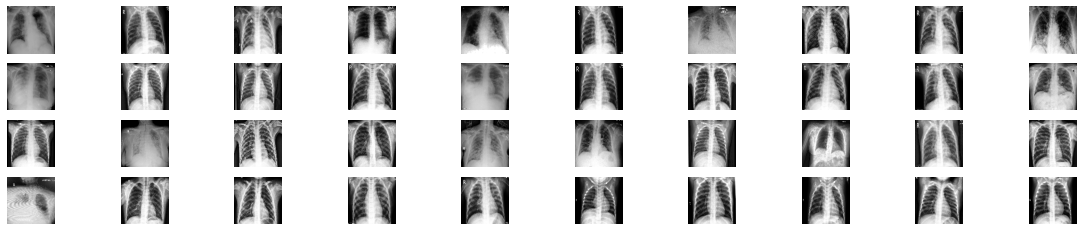

In [ ]:
# example of data for one client
figure = plt.figure(figsize=(20,4))
j = 0

for sample in sample_dataset_even.take(40):
    plt.subplot(4, 10, j+1)
    plt.imshow(sample['pixels'].numpy(), cmap = 'gray', aspect='equal')
    plt.axis('off')
    j += 1


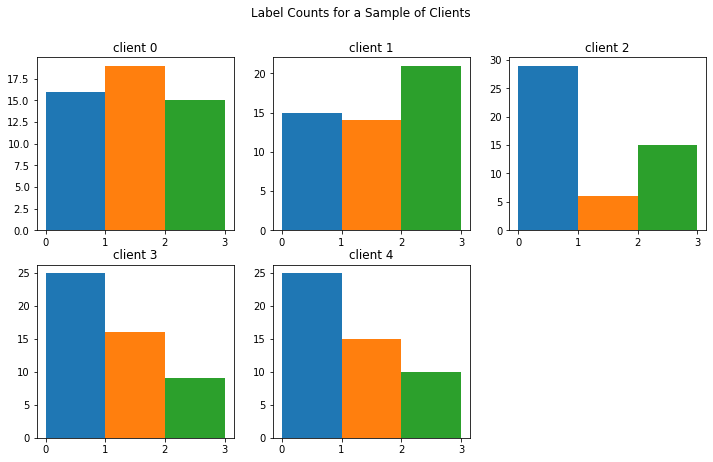

In [ ]:
# Number of examples per layer for a sample of clients 
f = plt.figure(figsize=(12, 7))
f.suptitle('Label Counts for a Sample of Clients')

for i in range(client_number):
    client_dataset = client_train_dataset_even.create_tf_dataset_for_client(
        client_train_dataset_even.client_ids[i]
    )

    plot_data = collections.defaultdict(list)


    for sample in client_dataset:
        label = sample['label'].numpy()
        plot_data[label].append(label)
    
    plt.subplot(2, 3, i+1)
    plt.title(f'client {i}')
    for j in range(10):
        plt.hist(
            plot_data[j],
            density= False,
            bins = [0,1,2,3]
        )

In [ ]:
SHUFFLE_BUFFER = image_per_set
SHUFFLE_BUFFER

50

In [ ]:
# dataset preprocessing, reshaping x and y values
def preprocess(dataset):
    print(type(dataset))
    def batch_format_fn(element):        
        """Flatten a batch `pixels` and return the features as an `OrderedDict`."""
        return collections.OrderedDict(
            x = tf.reshape(element['pixels'], [-1, size, size, 1]),
            y = tf.reshape(element['label'], [-1, 1])
        )
    
    return dataset.repeat(NUM_EPOCHS).shuffle(SHUFFLE_BUFFER, seed = 1).batch(BATCH_SIZE).map(batch_format_fn).prefetch(PREFETCH_BUFFER)

In [ ]:
preprocessed_sample_dataset = preprocess(sample_dataset_even)
sample_batch = tf.nest.map_structure(lambda x: x.numpy(), next(iter(preprocessed_sample_dataset)))

<class 'tensorflow.python.data.ops.dataset_ops.TensorSliceDataset'>


In [ ]:
# function for preparing datasets to be used during federated model evaluation 
def make_federated_data(client_data, client_ids):
    return [preprocess(client_data.create_tf_dataset_for_client(x)) for x in client_ids]

In [ ]:
# converting datasets for federated learning
federated_train_data_even = make_federated_data(client_train_dataset_even, client_train_dataset_even.client_ids)

<class 'tensorflow.python.data.ops.dataset_ops.TensorSliceDataset'>
<class 'tensorflow.python.data.ops.dataset_ops.TensorSliceDataset'>
<class 'tensorflow.python.data.ops.dataset_ops.TensorSliceDataset'>
<class 'tensorflow.python.data.ops.dataset_ops.TensorSliceDataset'>
<class 'tensorflow.python.data.ops.dataset_ops.TensorSliceDataset'>


In [ ]:
print('Number of client datasets: {l}'.format(l=len(federated_train_data_even)))
print('First dataset: {d}'.format(d=federated_train_data_even[0]))

Number of client datasets: 5
First dataset: <PrefetchDataset shapes: OrderedDict([(x, (None, 96, 96, 1)), (y, (None, 1))]), types: OrderedDict([(x, tf.float32), (y, tf.int32)])>


In [ ]:
normal_model = create_keras_model() # model initialization

# compiling model 
normal_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

# fitting model where training starts 
history = normal_model.fit(x_train_covid, y_train_covid, batch_size=5, epochs=20, validation_data=(x_test_covid, y_test_covid))
# normal_model.save(model_dir / "without_tff_model.h5")

Train on 251 samples, validate on 66 samples
Epoch 1/20
251/251 [==============================] - 5s 21ms/sample - loss: 75.6012 - sparse_categorical_accuracy: 0.6932 - val_loss: 1.0506 - val_sparse_categorical_accuracy: 0.7273
Epoch 2/20
251/251 [==============================] - 5s 21ms/sample - loss: 0.5909 - sparse_categorical_accuracy: 0.8924 - val_loss: 0.8063 - val_sparse_categorical_accuracy: 0.7424
Epoch 3/20
251/251 [==============================] - 5s 21ms/sample - loss: 0.3995 - sparse_categorical_accuracy: 0.8845 - val_loss: 0.8147 - val_sparse_categorical_accuracy: 0.7727
Epoch 4/20
251/251 [==============================] - 5s 21ms/sample - loss: 0.1496 - sparse_categorical_accuracy: 0.9522 - val_loss: 0.8744 - val_sparse_categorical_accuracy: 0.8485
Epoch 5/20
251/251 [==============================] - 5s 21ms/sample - loss: 0.5420 - sparse_categorical_accuracy: 0.9641 - val_loss: 0.9685 - val_sparse_categorical_accuracy: 0.7879
Epoch 6/20
251/251 [===================

In [ ]:
# making prediction on trained model
prediction_covid = normal_model.predict_classes(x_test_covid)

In [ ]:
cm_covid = confusion_matrix(y_test_covid, prediction_covid)

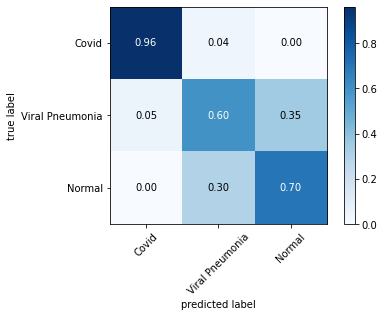

In [ ]:
# plotting confusion matrix using MLxtend library
fig, ax = plot_confusion_matrix(conf_mat=cm_covid,
                                colorbar=True,
                                show_absolute=False,
                                show_normed=True,
                                class_names = ['Covid', 'Viral Pneumonia', 'Normal'])
plt.show()

In [ ]:
print(classification_report(y_test_covid, prediction_covid, target_names=['Covid', 'Viral Pneumonia', 'Normal']))

                 precision    recall  f1-score   support

          Covid       0.96      0.96      0.96        26
Viral Pneumonia       0.63      0.60      0.62        20
         Normal       0.67      0.70      0.68        20

       accuracy                           0.77        66
      macro avg       0.75      0.75      0.75        66
   weighted avg       0.77      0.77      0.77        66



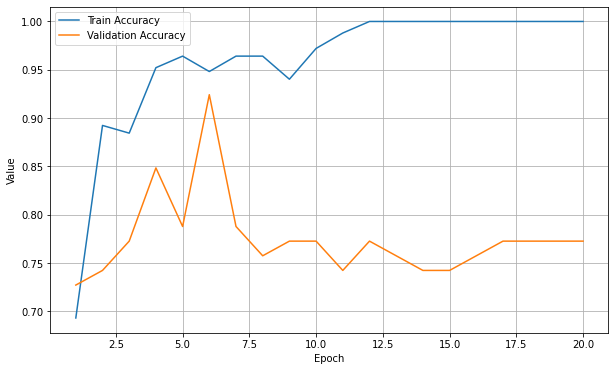

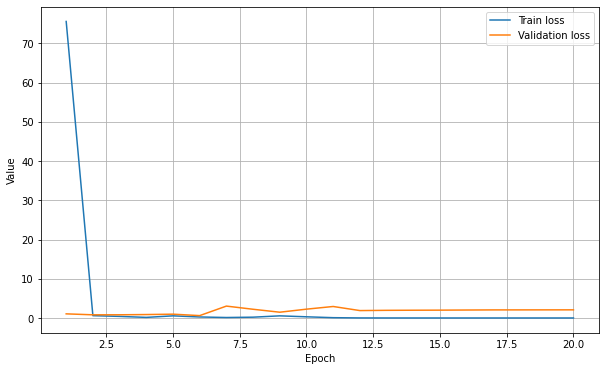

In [ ]:
# plotting learning curves using matplotlib
fig = plt.figure(figsize=(10, 6))
plot_graph(range(1, len(history.epoch)+1), history.history['sparse_categorical_accuracy'], label='Train Accuracy')
plot_graph(range(1, len(history.epoch)+1), history.history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
plt.legend()
plt.savefig(output_dir / "normal_model_Accuracy.png")

plt.figure(figsize=(10, 6))
plot_graph(range(1, len(history.epoch)+1), history.history['loss'], label='Train loss')
plot_graph(range(1, len(history.epoch)+1), history.history['val_loss'], label='Validation loss')
plt.legend()
plt.savefig(output_dir / "normal_model_loss.png")


In [ ]:
# creating tff keras model using base model
def model_fn():
    # TFF will call this within different graph contexts.

    keras_model = create_keras_model()
    # keras_model.trainable = True,
    return tff.learning.from_keras_model(
        keras_model,
        input_spec = preprocessed_sample_dataset.element_spec,
        loss = tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]
    ) 

In [ ]:
# constructing a TFF Federated Averaging algorithm by invoking the helper function tff.learning.build_federated_averaging_process
iterative_process = tff.learning.build_federated_averaging_process(
    model_fn,
    client_optimizer_fn=lambda: tf.keras.optimizers.Adam(learning_rate=client_lr),
    server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=server_lr))

In [ ]:
print(str(iterative_process.initialize.type_signature.formatted_representation()))

( -> <
  model=<
    trainable=<
      float32[3,3,1,32],
      float32[32],
      float32[3,3,32,64],
      float32[64],
      float32[30976,512],
      float32[512],
      float32[512,3],
      float32[3]
    >,
    non_trainable=<>
  >,
  optimizer_state=<
    int64
  >,
  delta_aggregate_state=<>,
  model_broadcast_state=<>
>@SERVER)


In [ ]:
state = iterative_process.initialize()

tff_train_acc = []
tff_val_acc = []
tff_train_loss = []
tff_val_loss = []

In [ ]:
import os 
logs = "logs_even"
if not os.path.exists(logs):
    os.makedirs(logs)
for i in os.listdir(logs):
    os.remove(f'{logs}/{i}')

summary_writer = tf.summary.create_file_writer(logs)
state = iterative_process.initialize()

In [ ]:
with summary_writer.as_default():
    eval_model = None
    for round_num in range(1, NUM_ROUNDS+1): # running training of NUM_ROUNDS and visualizing results
        state, metrics = iterative_process.next(state, federated_train_data_even)
      
        print('round {:2d}, metrics={}'.format(round_num, metrics))
        
        name = ['sparse_categorical_accuracy', 'loss']

        for i in range(2):
            tf.summary.scalar(name[i], metrics[i], step=round_num) # assigning values of tensorboard visualisation

        eval_model = create_keras_model() # creating evaluation model
        eval_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                       loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                       metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

        tff.learning.assign_weights_to_keras_model(eval_model, state.model) # updating model weights

        ev_result = eval_model.evaluate(x_test_covid, y_test_covid, verbose=0) # evaluating models on test set
        print('round {:2d}, metrics={}'.format(round_num, metrics))
        print(f"Eval loss : {ev_result[0]} and Eval accuracy : {ev_result[1]}")
        tff_train_acc.append(float(metrics.sparse_categorical_accuracy))
        tff_val_acc.append(ev_result[1])
        tff_train_loss.append(float(metrics.loss))
        tff_val_loss.append(ev_result[0])


ERROR:asyncio:Task was destroyed but it is pending!
task: <Task pending coro=<trace.<locals>.async_trace() running at /home/jitu-fx516/anaconda3/envs/fed36/lib/python3.6/site-packages/tensorflow_federated/python/common_libs/tracing.py:281> wait_for=<Future pending cb=[_chain_future.<locals>._call_check_cancel() at /home/jitu-fx516/anaconda3/envs/fed36/lib/python3.6/asyncio/futures.py:403, Task._wakeup()]> cb=[Task._wakeup(), <1 more>, Task._wakeup()]>


round  1, metrics=<sparse_categorical_accuracy=0.6384000182151794,loss=1.9419633150100708,keras_training_time_client_sum_sec=0.0>
round  1, metrics=<sparse_categorical_accuracy=0.6384000182151794,loss=1.9419633150100708,keras_training_time_client_sum_sec=0.0>
Eval loss : 1.100042785658981 and Eval accuracy : 0.42424243688583374
round  2, metrics=<sparse_categorical_accuracy=0.7251999974250793,loss=0.6610231995582581,keras_training_time_client_sum_sec=0.0>
round  2, metrics=<sparse_categorical_accuracy=0.7251999974250793,loss=0.6610231995582581,keras_training_time_client_sum_sec=0.0>
Eval loss : 1.411027232805888 and Eval accuracy : 0.4848484992980957
round  3, metrics=<sparse_categorical_accuracy=0.7224000096321106,loss=0.6566824913024902,keras_training_time_client_sum_sec=0.0>
round  3, metrics=<sparse_categorical_accuracy=0.7224000096321106,loss=0.6566824913024902,keras_training_time_client_sum_sec=0.0>
Eval loss : 1.0587512543707183 and Eval accuracy : 0.5303030014038086
round  4, m

In [ ]:
!ls {logs_even}
%tensorboard --logdir {logs} --port=0

[0.6384000182151794, 0.7251999974250793, 0.7224000096321106, 0.7279999852180481, 0.7595999836921692, 0.7799999713897705, 0.8167999982833862, 0.8267999887466431, 0.8087999820709229, 0.8223999738693237, 0.8180000185966492, 0.7731999754905701, 0.7940000295639038, 0.840399980545044, 0.8331999778747559, 0.8763999938964844, 0.8307999968528748, 0.8396000266075134, 0.8432000279426575, 0.8619999885559082] [0.42424244, 0.4848485, 0.530303, 0.530303, 0.56060606, 0.57575756, 0.56060606, 0.57575756, 0.54545456, 0.59090906, 0.59090906, 0.6212121, 0.57575756, 0.59090906, 0.59090906, 0.6060606, 0.56060606, 0.6212121, 0.59090906, 0.6060606] [1.9419633150100708, 0.6610231995582581, 0.6566824913024902, 0.6273135542869568, 0.6051735877990723, 0.6166631579399109, 0.5182517766952515, 0.5156118869781494, 0.4674976170063019, 0.5065549612045288, 0.4743853509426117, 0.5637632012367249, 0.4836674928665161, 0.5099985599517822, 0.44117772579193115, 0.35449427366256714, 0.4646025002002716, 0.4743206202983856, 0.412

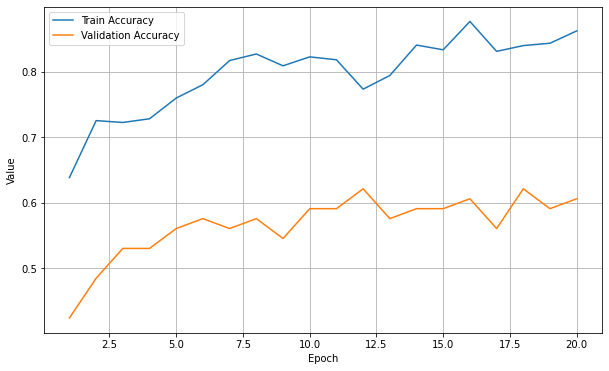

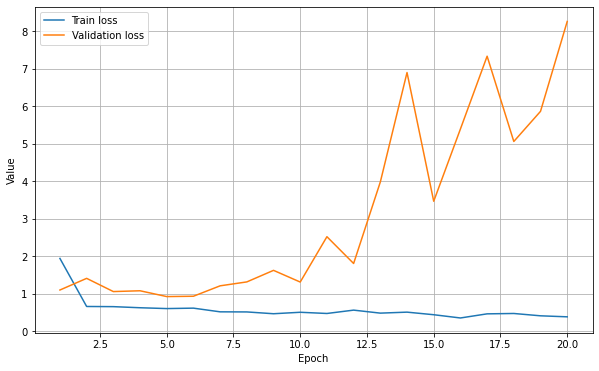

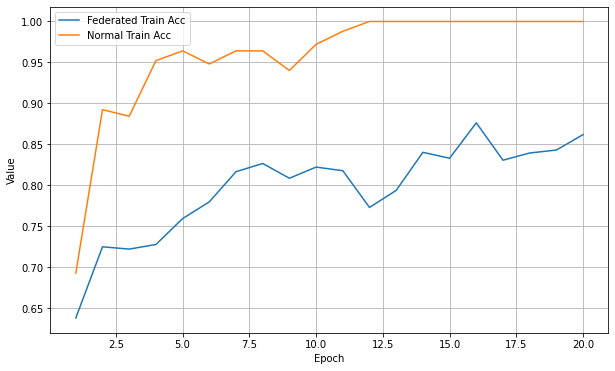

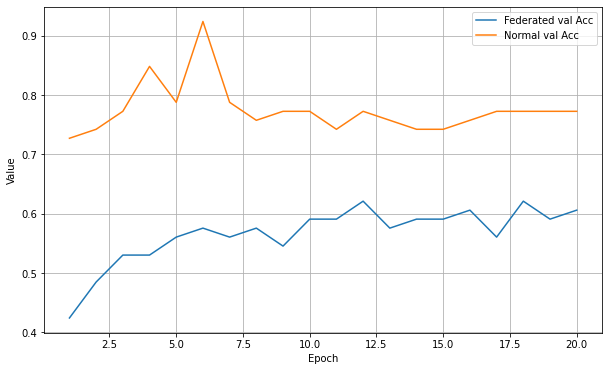

In [ ]:
# plotting learning curves for federatted machine learning model
print(tff_train_acc, tff_val_acc, tff_train_loss, tff_val_loss)
fig = plt.figure(figsize=(10, 6))
plot_graph(list(range(1, len(tff_train_acc)+1)), tff_train_acc, label='Train Accuracy')
plot_graph(list(range(1, len(tff_val_acc)+1)), tff_val_acc, label='Validation Accuracy')
plt.legend()
plt.savefig(output_dir / "federated_model_Accuracy.png")

plt.figure(figsize=(10, 6))
plot_graph(list(range(1, len(tff_train_acc)+1)), tff_train_loss, label='Train loss')
plot_graph(list(range(1, len(tff_train_acc)+1)), tff_val_loss, label='Validation loss')
plt.legend()
plt.savefig(output_dir / "federated_model_loss.png")

plt.figure(figsize=(10, 6))
plot_graph(list(range(1, len(tff_train_acc)+1)), tff_train_acc, label='Federated Train Acc')
plot_graph(range(1, len(history.epoch)+1), history.history['sparse_categorical_accuracy'], label='Normal Train Acc')
plt.legend()
plt.savefig(output_dir / "federated_v_s_normal_model_train_Accuracy.png")

plt.figure(figsize=(10, 6))
plot_graph(list(range(1, len(tff_train_acc)+1)), tff_val_acc, label='Federated val Acc')
plot_graph(range(1, len(history.epoch)+1), history.history['val_sparse_categorical_accuracy'], label='Normal val Acc')
plt.legend()
plt.savefig(output_dir / "federated_v_s_normal_model_validation_Accuracy.png")

In [ ]:
fed_pred_covid = eval_model.predict_classes(x_test_covid)
fed_cm_covid =  confusion_matrix(y_test_covid, fed_pred_covid)

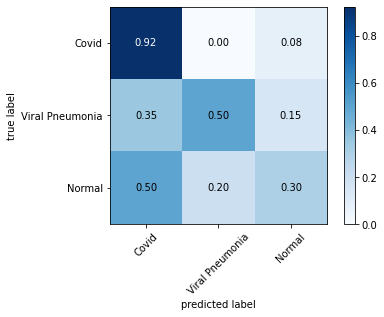

In [ ]:
# plotting confusion matrix
fig, ax = plot_confusion_matrix(conf_mat=fed_cm_covid,
                                colorbar=True,
                                show_absolute=False,
                                show_normed=True,
                                class_names = ['Covid', 'Viral Pneumonia', 'Normal'])
plt.show()

In [ ]:
print(classification_report(y_test_covid, fed_pred_covid, target_names=['Covid', 'Viral Pneumonia', 'Normal']))

                 precision    recall  f1-score   support

          Covid       0.59      0.92      0.72        26
Viral Pneumonia       0.71      0.50      0.59        20
         Normal       0.55      0.30      0.39        20

       accuracy                           0.61        66
      macro avg       0.62      0.57      0.56        66
   weighted avg       0.61      0.61      0.58        66



### #2 evaluation on uneven data distribution


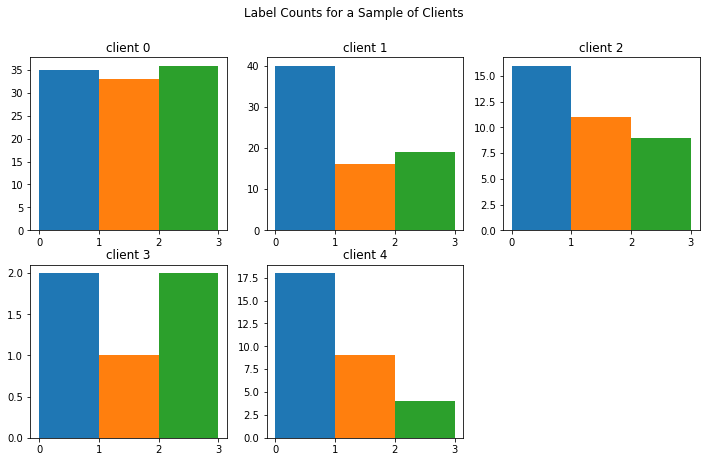

In [ ]:
# Number of examples per layer for a sample of clients 
client_train_dataset_uneven =  tff.simulation.FromTensorSlicesClientData(client_train_dataset_uneven)

f = plt.figure(figsize=(12, 7))
f.suptitle('Label Counts for a Sample of Clients')

for i in range(client_number):
    client_dataset = client_train_dataset_uneven.create_tf_dataset_for_client(
        client_train_dataset_uneven.client_ids[i]
    )

    plot_data = collections.defaultdict(list)


    for sample in client_dataset:
        label = sample['label'].numpy()
        plot_data[label].append(label)
    
    plt.subplot(2, 3, i+1)
    plt.title(f'client {i}')
    for j in range(10):
        plt.hist(
            plot_data[j],
            density= False,
            bins = [0,1,2,3]
        )

In [ ]:
# converting datasets for federated learning
federated_train_data_uneven = make_federated_data(client_train_dataset_uneven, client_train_dataset_uneven.client_ids)

<class 'tensorflow.python.data.ops.dataset_ops.TensorSliceDataset'>
<class 'tensorflow.python.data.ops.dataset_ops.TensorSliceDataset'>
<class 'tensorflow.python.data.ops.dataset_ops.TensorSliceDataset'>
<class 'tensorflow.python.data.ops.dataset_ops.TensorSliceDataset'>
<class 'tensorflow.python.data.ops.dataset_ops.TensorSliceDataset'>


In [ ]:
print('Number of client datasets: {l}'.format(l=len(federated_train_data_even)))
print('First dataset: {d}'.format(d=federated_train_data_even[0]))

Number of client datasets: 5
First dataset: <PrefetchDataset shapes: OrderedDict([(x, (None, 96, 96, 1)), (y, (None, 1))]), types: OrderedDict([(x, tf.float32), (y, tf.int32)])>


In [ ]:
tff_train_acc_u = []
tff_val_acc_u = []
tff_train_loss_u = []
tff_val_loss_u = []

In [ ]:
import os 
logs = "logs_uneven"
if not os.path.exists(logs):
    os.makedirs(logs)
for i in os.listdir(logs):
    os.remove(f'{logs}/{i}')

summary_writer = tf.summary.create_file_writer(logs)
state = iterative_process.initialize()

In [ ]:
with summary_writer.as_default():
    eval_model_u = None
    for round_num in range(1, NUM_ROUNDS+1): # running training of NUM_ROUNDS and visualizing results
        state, metrics = iterative_process.next(state, federated_train_data_uneven)
      
        print('round {:2d}, metrics={}'.format(round_num, metrics))
        
        # for name, value in metrics['client_work']['train'].items():
        name = ['sparse_categorical_accuracy', 'loss']

        for i in range(2):
            tf.summary.scalar(name[i], metrics[i], step=round_num) # assigning values of tensorboard visualisation

        eval_model_u = create_keras_model() # creating evaluation model
        eval_model_u.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                       loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                       metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

        tff.learning.assign_weights_to_keras_model(eval_model_u, state.model) # updating model weights

        ev_result = eval_model_u.evaluate(x_test_covid, y_test_covid, verbose=0) # evaluating models on test set
        print('round {:2d}, metrics={}'.format(round_num, metrics))
        print(f"Eval loss : {ev_result[0]} and Eval accuracy : {ev_result[1]}")
        tff_train_acc_u.append(float(metrics.sparse_categorical_accuracy))
        tff_val_acc_u.append(ev_result[1])
        tff_train_loss_u.append(float(metrics.loss))
        tff_val_loss_u.append(ev_result[0])


round  1, metrics=<sparse_categorical_accuracy=0.8083665370941162,loss=1.5694172382354736,keras_training_time_client_sum_sec=0.0>
round  1, metrics=<sparse_categorical_accuracy=0.8083665370941162,loss=1.5694172382354736,keras_training_time_client_sum_sec=0.0>
Eval loss : 1.4745718638102214 and Eval accuracy : 0.43939393758773804
round  2, metrics=<sparse_categorical_accuracy=0.8286852836608887,loss=0.6670863032341003,keras_training_time_client_sum_sec=0.0>
round  2, metrics=<sparse_categorical_accuracy=0.8286852836608887,loss=0.6670863032341003,keras_training_time_client_sum_sec=0.0>
Eval loss : 1.2686563224503489 and Eval accuracy : 0.5151515007019043
round  3, metrics=<sparse_categorical_accuracy=0.8796812891960144,loss=0.6406721472740173,keras_training_time_client_sum_sec=0.0>
round  3, metrics=<sparse_categorical_accuracy=0.8796812891960144,loss=0.6406721472740173,keras_training_time_client_sum_sec=0.0>
Eval loss : 1.490369869226759 and Eval accuracy : 0.6666666865348816
round  4, 

In [ ]:
!ls {logs_uneven}
%tensorboard --logdir {logs} --port=0

[0.8083665370941162, 0.8286852836608887, 0.8796812891960144, 0.9458167552947998, 0.9247012138366699, 0.9314740896224976, 0.909960150718689, 0.9374501705169678, 0.9501991868019104, 0.9537848830223083, 0.9609561562538147, 0.9721115827560425, 0.9780876636505127, 0.9932270646095276, 0.9745019674301147, 0.9621514081954956, 0.9868525862693787, 0.9948207139968872, 0.9940239191055298, 0.9980079531669617] [0.43939394, 0.5151515, 0.6666667, 0.56060606, 0.59090906, 0.59090906, 0.6060606, 0.6363636, 0.6363636, 0.6363636, 0.74242425, 0.7121212, 0.6818182, 0.77272725, 0.6666667, 0.74242425, 0.77272725, 0.8181818, 0.77272725, 0.8030303] [1.5694172382354736, 0.6670863032341003, 0.6406721472740173, 0.3176437020301819, 0.5000430345535278, 0.4070136547088623, 0.5539344549179077, 0.3862811028957367, 0.354351282119751, 0.26494404673576355, 0.33329150080680847, 0.3260684609413147, 0.28177526593208313, 0.08894422650337219, 0.2886104881763458, 0.3623162508010864, 0.15717174112796783, 0.07795188575983047, 0.07

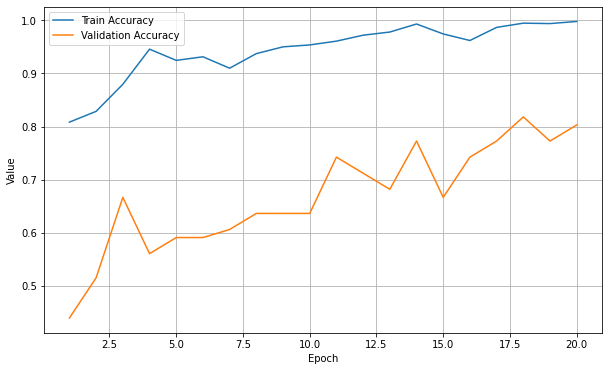

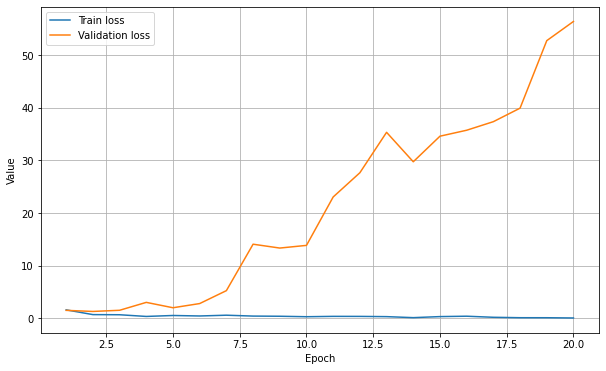

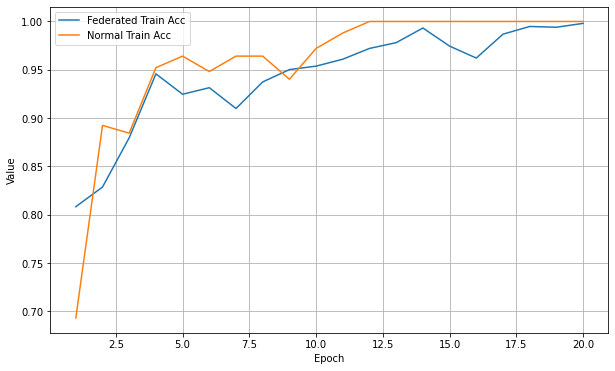

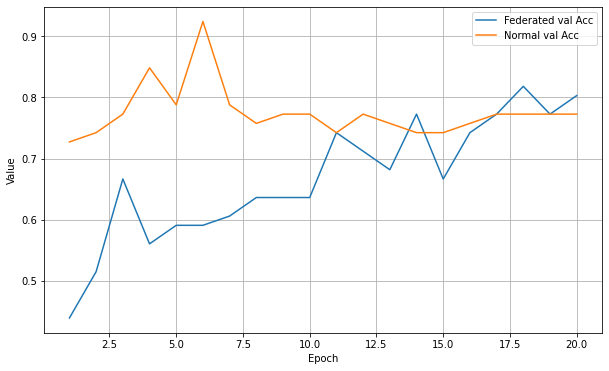

In [ ]:
# plotting learning curves for federatted machine learning model
print(tff_train_acc_u, tff_val_acc_u, tff_train_loss_u, tff_val_loss_u)
fig = plt.figure(figsize=(10, 6))
plot_graph(list(range(1, len(tff_train_acc_u)+1)), tff_train_acc_u, label='Train Accuracy')
plot_graph(list(range(1, len(tff_val_acc_u)+1)), tff_val_acc_u, label='Validation Accuracy')
plt.legend()
plt.savefig(output_dir / "federated_model_Accuracy.png")

plt.figure(figsize=(10, 6))
plot_graph(list(range(1, len(tff_train_acc_u)+1)), tff_train_loss_u, label='Train loss')
plot_graph(list(range(1, len(tff_train_acc_u)+1)), tff_val_loss_u, label='Validation loss')
plt.legend()
plt.savefig(output_dir / "federated_model_loss.png")

plt.figure(figsize=(10, 6))
plot_graph(list(range(1, len(tff_train_acc_u)+1)), tff_train_acc_u, label='Federated Train Acc')
plot_graph(range(1, len(history.epoch)+1), history.history['sparse_categorical_accuracy'], label='Normal Train Acc')
plt.legend()
plt.savefig(output_dir / "federated_v_s_normal_model_train_Accuracy.png")

plt.figure(figsize=(10, 6))
plot_graph(list(range(1, len(tff_train_acc_u)+1)), tff_val_acc_u, label='Federated val Acc')
plot_graph(range(1, len(history.epoch)+1), history.history['val_sparse_categorical_accuracy'], label='Normal val Acc')
plt.legend()
plt.savefig(output_dir / "federated_v_s_normal_model_validation_Accuracy.png")

In [ ]:
fed_pred_covid_u = eval_model_u.predict_classes(x_test_covid)
fed_cm_covid_u =  confusion_matrix(y_test_covid, fed_pred_covid_u)

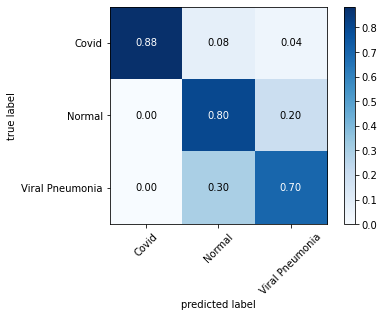

In [ ]:
# plotting confusion matrix
fig, ax = plot_confusion_matrix(conf_mat=fed_cm_covid_u,
                                colorbar=True,
                                show_absolute=False,
                                show_normed=True,
                                class_names = ['Covid', 'Normal', 'Viral Pneumonia'])
plt.show()

In [ ]:
print(classification_report(y_test_covid, fed_pred_covid_u, target_names=['Covid', 'Normal', 'Viral Pneumonia']))

                 precision    recall  f1-score   support

          Covid       1.00      0.88      0.94        26
         Normal       0.67      0.80      0.73        20
Viral Pneumonia       0.74      0.70      0.72        20

       accuracy                           0.80        66
      macro avg       0.80      0.79      0.79        66
   weighted avg       0.82      0.80      0.81        66



### 3. Evalution where certain client does not have certain dataset

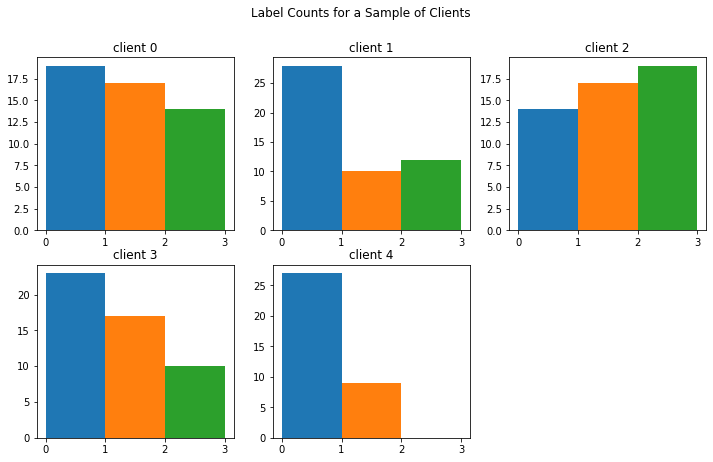

In [ ]:
# Number of examples per layer for a sample of clients 
client_train_dataset_1 =  tff.simulation.FromTensorSlicesClientData(client_train_dataset_1)

f = plt.figure(figsize=(12, 7))
f.suptitle('Label Counts for a Sample of Clients')

for i in range(client_number):
    client_dataset = client_train_dataset_1.create_tf_dataset_for_client(
        client_train_dataset_1.client_ids[i]
    )

    plot_data = collections.defaultdict(list)


    for sample in client_dataset:
        label = sample['label'].numpy()
        plot_data[label].append(label)
    
    plt.subplot(2, 3, i+1)
    plt.title(f'client {i}')
    for j in range(10):
        plt.hist(
            plot_data[j],
            density= False,
            bins = [0,1,2,3]
        )

In [ ]:
federated_train_data_1 = make_federated_data(client_train_dataset_1, client_train_dataset_1.client_ids)

<class 'tensorflow.python.data.ops.dataset_ops.TensorSliceDataset'>
<class 'tensorflow.python.data.ops.dataset_ops.TensorSliceDataset'>
<class 'tensorflow.python.data.ops.dataset_ops.TensorSliceDataset'>
<class 'tensorflow.python.data.ops.dataset_ops.TensorSliceDataset'>
<class 'tensorflow.python.data.ops.dataset_ops.TensorSliceDataset'>


In [ ]:
print('Number of client datasets: {l}'.format(l=len(federated_train_data_even)))
print('First dataset: {d}'.format(d=federated_train_data_even[0]))

Number of client datasets: 5
First dataset: <PrefetchDataset shapes: OrderedDict([(x, (None, 96, 96, 1)), (y, (None, 1))]), types: OrderedDict([(x, tf.float32), (y, tf.int32)])>


In [ ]:
tff_train_acc_1 = []
tff_val_acc_1 = []
tff_train_loss_1 = []
tff_val_loss_1 = []

In [ ]:
import os 
logs = "logs_1"
if not os.path.exists(logs):
    os.makedirs(logs)
for i in os.listdir(logs):
    os.remove(f'{logs}/{i}')

summary_writer = tf.summary.create_file_writer(logs)
state = iterative_process.initialize()

In [ ]:
with summary_writer.as_default():
    eval_model_1 = None
    for round_num in range(1, NUM_ROUNDS+1): # running training of NUM_ROUNDS and visualizing results
        state, metrics = iterative_process.next(state, federated_train_data_1)
      
        print('round {:2d}, metrics={}'.format(round_num, metrics))
        
        name = ['sparse_categorical_accuracy', 'loss']

        for i in range(2):
            tf.summary.scalar(name[i], metrics[i], step=round_num) # assigning values of tensorboard visualisation

        eval_model_1 = create_keras_model() # creating evaluation model
        eval_model_1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                       loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                       metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

        tff.learning.assign_weights_to_keras_model(eval_model_1, state.model) # updating model weights

        ev_result = eval_model_1.evaluate(x_test_covid, y_test_covid, verbose=0) # evaluating models on test set
        print('round {:2d}, metrics={}'.format(round_num, metrics))
        print(f"Eval loss : {ev_result[0]} and Eval accuracy : {ev_result[1]}")
        tff_train_acc_1.append(float(metrics.sparse_categorical_accuracy))
        tff_val_acc_1.append(ev_result[1])
        tff_train_loss_1.append(float(metrics.loss))
        tff_val_loss_1.append(ev_result[0])

round  1, metrics=<sparse_categorical_accuracy=0.7186440825462341,loss=2.446465492248535,keras_training_time_client_sum_sec=0.0>
round  1, metrics=<sparse_categorical_accuracy=0.7186440825462341,loss=2.446465492248535,keras_training_time_client_sum_sec=0.0>
Eval loss : 0.9736560366370461 and Eval accuracy : 0.6666666865348816
round  2, metrics=<sparse_categorical_accuracy=0.7728813290596008,loss=0.8736851811408997,keras_training_time_client_sum_sec=0.0>
round  2, metrics=<sparse_categorical_accuracy=0.7728813290596008,loss=0.8736851811408997,keras_training_time_client_sum_sec=0.0>
Eval loss : 1.166026922789487 and Eval accuracy : 0.5
round  3, metrics=<sparse_categorical_accuracy=0.7847457528114319,loss=0.7583802938461304,keras_training_time_client_sum_sec=0.0>
round  3, metrics=<sparse_categorical_accuracy=0.7847457528114319,loss=0.7583802938461304,keras_training_time_client_sum_sec=0.0>
Eval loss : 0.9620942708217737 and Eval accuracy : 0.5151515007019043
round  4, metrics=<sparse_ca

: 

: 

In [ ]:
!ls {logs_1}
%tensorboard --logdir {logs} --port=0

In [ ]:
# plotting learning curves for federatted machine learning model
print(tff_train_acc_1, tff_val_acc_1, tff_train_loss_1, tff_val_loss_1)
fig = plt.figure(figsize=(10, 6))
plot_graph(list(range(1, len(tff_train_acc_1)+1)), tff_train_acc_1, label='Train Accuracy')
plot_graph(list(range(1, len(tff_val_acc_1)+1)), tff_val_acc_1, label='Validation Accuracy')
plt.legend()
plt.savefig(output_dir / "federated_model_Accuracy.png")

plt.figure(figsize=(10, 6))
plot_graph(list(range(1, len(tff_train_acc_1)+1)), tff_train_loss_1, label='Train loss')
plot_graph(list(range(1, len(tff_train_acc_1)+1)), tff_val_loss_1, label='Validation loss')
plt.legend()
plt.savefig(output_dir / "federated_model_loss.png")

plt.figure(figsize=(10, 6))
plot_graph(list(range(1, len(tff_train_acc_1)+1)), tff_train_acc_1, label='Federated Train Acc')
plot_graph(range(1, len(history.epoch)+1), history.history['sparse_categorical_accuracy'], label='Normal Train Acc')
plt.legend()
plt.savefig(output_dir / "federated_v_s_normal_model_train_Accuracy.png")

plt.figure(figsize=(10, 6))
plot_graph(list(range(1, len(tff_train_acc_1)+1)), tff_val_acc_1, label='Federated val Acc')
plot_graph(range(1, len(history.epoch)+1), history.history['val_sparse_categorical_accuracy'], label='Normal val Acc')
plt.legend()
plt.savefig(output_dir / "federated_v_s_normal_model_validation_Accuracy.png")

In [ ]:
fed_pred_covid_1 = eval_model_1.predict_classes(x_test_covid)
fed_cm_covid_1 =  confusion_matrix(y_test_covid, fed_pred_covid_1)

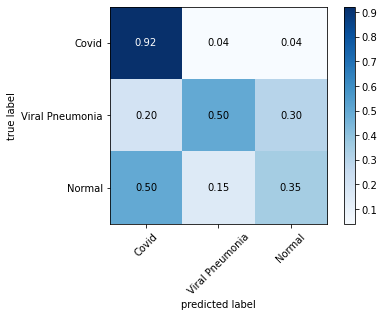

In [ ]:
# plotting confusion matrix
fig, ax = plot_confusion_matrix(conf_mat=fed_cm_covid_1,
                                colorbar=True,
                                show_absolute=False,
                                show_normed=True,
                                class_names = ['Covid', 'Viral Pneumonia', 'Normal'])
plt.show()

In [ ]:
print(classification_report(y_test_covid, fed_pred_covid_1, target_names=['Covid', 'Viral Pneumonia', 'Normal']))

                 precision    recall  f1-score   support

          Covid       0.63      0.92      0.75        26
Viral Pneumonia       0.71      0.50      0.59        20
         Normal       0.50      0.35      0.41        20

       accuracy                           0.62        66
      macro avg       0.62      0.59      0.58        66
   weighted avg       0.62      0.62      0.60        66



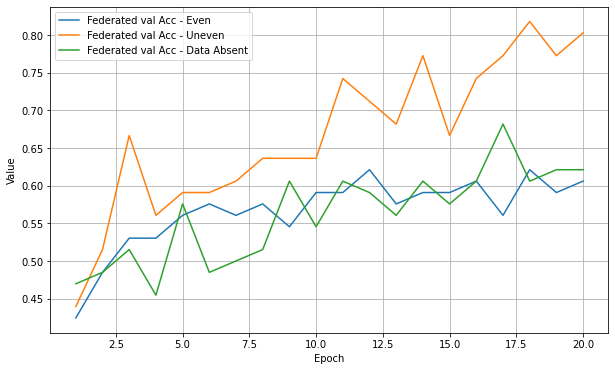

In [ ]:
# comparison between data distribution
plt.figure(figsize=(10,6))
plot_graph(list(range(1, len(tff_train_acc)+1)), tff_val_acc, label='Federated val Acc - Even')
plot_graph(list(range(1, len(tff_train_acc)+1)), tff_val_acc_u, label='Federated val Acc - Uneven')
plot_graph(list(range(1, len(tff_train_acc)+1)), tff_val_acc_1, label='Federated val Acc - Data Absent')
plt.legend()

plt.savefig(output_dir / "comparison_graph.png")




## 2 MNIST federated learning and normal algorithm training

In [ ]:
client_lr = 1e-2
server_lr = 1
client_number = 10
NUM_ROUNDS = 20
NUM_EPOCHS = 5
BATCH_SIZE = 100
PREFETCH_BUFFER = 10
size = 28

In [ ]:
# creating model with keras 
def create_keras_model():
    """ function for creating Convolutional Neural Network architecture 

    Returns:
        tf.Sequential: neural network model architecture
    """
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(size, size, 1)),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    return model

In [ ]:
(x_train_mnist, y_train_mnist), (x_test_mnist, y_test_mnist) = mnist.load_data()

In [ ]:
x_train_mnist = x_train_mnist.astype(np.float32)
x_train_mnist = x_train_mnist.reshape(60000, size, size, 1)
y_train_mnist = y_train_mnist.astype(np.int32)
x_test_mnist = x_test_mnist.astype(np.float32).reshape(10000, size, size, 1)
y_test_mnist = y_test_mnist.astype(np.int32).reshape(10000, 1)

In [ ]:
x_train_mnist.shape

(60000, 28, 28, 1)

In [ ]:
total_image_count = len(x_train_mnist)
image_per_set = int(np.floor(total_image_count/client_number))

In [ ]:
print(image_per_set)

6000


In [ ]:
# preparing client train datasets : Unevenly Distributed
client_train_dataset = collections.OrderedDict()
for i in range(1, client_number+1):
    client_name = "client_" + str(i)
    start = image_per_set * (i-1)
    end = image_per_set * i

    print(f"Adding data from {start} to {end} for client : {client_name}")
    data = collections.OrderedDict((('label', y_train_mnist[start:end]), ('pixels', x_train_mnist[start:end])))
    client_train_dataset[client_name] = data

Adding data from 0 to 6000 for client : client_1
Adding data from 6000 to 12000 for client : client_2
Adding data from 12000 to 18000 for client : client_3
Adding data from 18000 to 24000 for client : client_4
Adding data from 24000 to 30000 for client : client_5
Adding data from 30000 to 36000 for client : client_6
Adding data from 36000 to 42000 for client : client_7
Adding data from 42000 to 48000 for client : client_8
Adding data from 48000 to 54000 for client : client_9
Adding data from 54000 to 60000 for client : client_10


In [ ]:
train_dataset =  tff.simulation.FromTensorSlicesClientData(client_train_dataset)

In [ ]:
sample_dataset = train_dataset.create_tf_dataset_for_client(train_dataset.client_ids[0])
sample_element = next(iter(sample_dataset))

### **Exploring federated data** 

Users typically have various distributions of data depending on consumption habits in federated data, which is typically non-i.i.d. Due to a local data shortage, some clients may have fewer training examples on their devices, while others may have an abundance of training examples. 

With the help of the EMNIST data, let's investigate this idea of data typical of a federated system. 

It's crucial to remember that because this is a simulation environment and all the data is available to us locally. You wouldn't be able to view any client's data in a genuine production federated system.

To get a sense of the examples on one simulated device, let's first take a sample of data from one client. The data of one client represents the handwriting of one individual for a sample of the numbers 0 through 9, replicating the distinctive "use pattern" of one user because the dataset we're utilising has been keyed by unique writer.

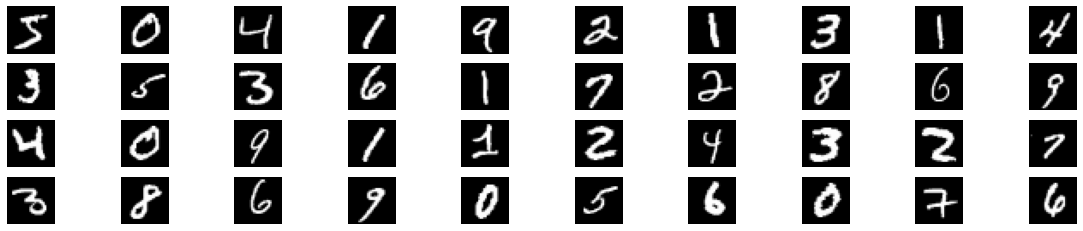

In [ ]:
# example of data for one client
figure = plt.figure(figsize=(20,4))
j = 0

for sample in sample_dataset.take(40):
    plt.subplot(4, 10, j+1)
    plt.imshow(sample['pixels'].numpy(), cmap = 'gray', aspect='equal')
    plt.axis('off')
    j += 1


Let's now display how many instances of each MNIST digit label there are for each client. Depending on user activity, the number of examples on each client in a federated system can vary significantly.

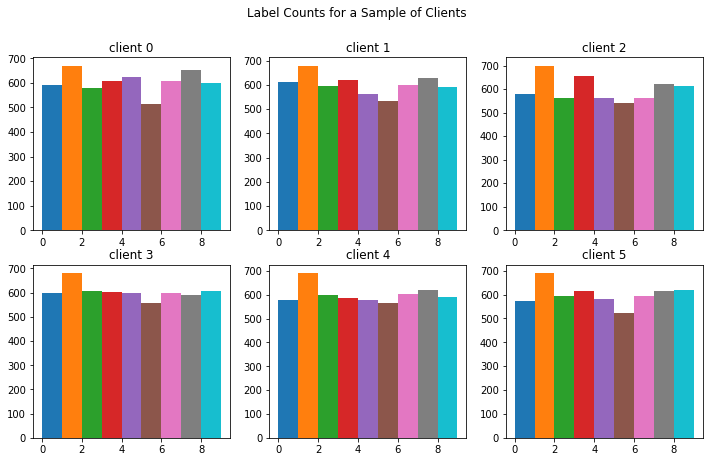

In [ ]:
# Number of examples per layer for a sample of clients 
f = plt.figure(figsize=(12, 7))
f.suptitle('Label Counts for a Sample of Clients')

for i in range(6):
    client_dataset = train_dataset.create_tf_dataset_for_client(
        train_dataset.client_ids[i]
    )

    plot_data = collections.defaultdict(list)


    for sample in client_dataset:
        label = sample['label'].numpy()
        plot_data[label].append(label)
    
    plt.subplot(2, 3, i+1)
    plt.title(f'client {i}')
    for j in range(10):
        plt.hist(
            plot_data[j],
            density= False,
            bins = [0,1,2,3,4,5,6,7,8,9]
        )

Let's now display the average image for each MNIST label across all clients. This function will generate the average pixel value for each user sample for a single label. We'll observe that each person's own handwriting style causes their mean image of a given digit to differ from the mean image of that same digit created by another client.

Since we are learning from each user's particular data in that local round, we can predict about how each local training round will cause the model to move in a distinct manner on each client.

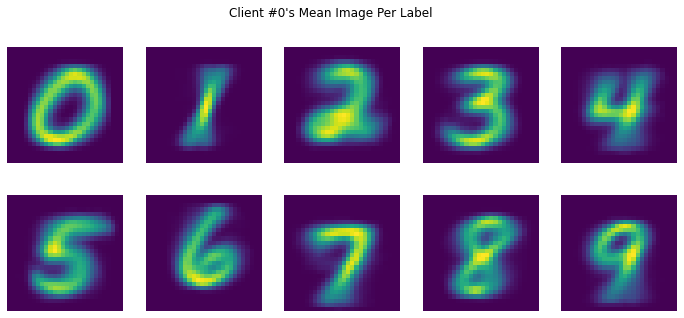

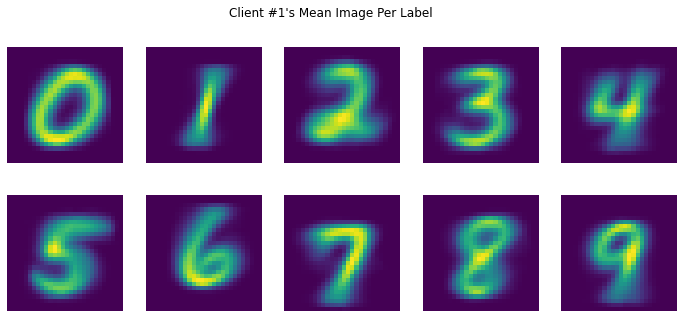

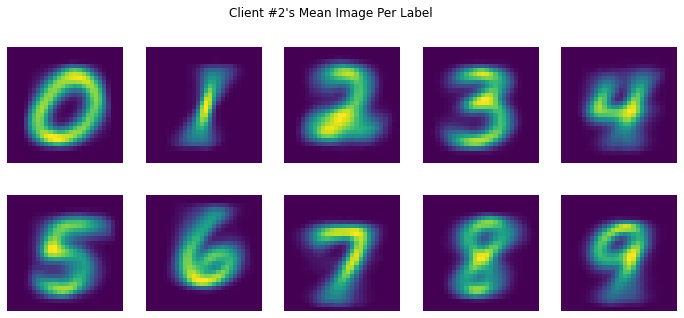

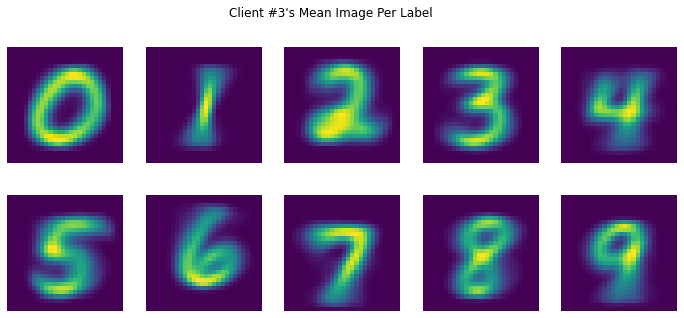

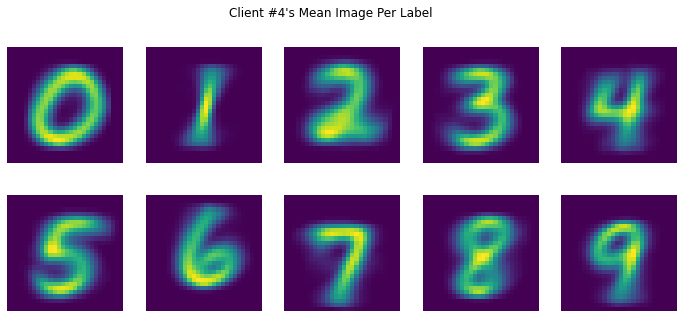

In [ ]:
# Each client has different mean images, meaning each client will be nudging
# the model in their own directions locally.

for i in range(5):
  client_dataset = train_dataset.create_tf_dataset_for_client(
      train_dataset.client_ids[i])
  plot_data = collections.defaultdict(list)
  for example in client_dataset:
    plot_data[example['label'].numpy()].append(example['pixels'].numpy())
  f = plt.figure(i, figsize=(12, 5))
  f.suptitle("Client #{}'s Mean Image Per Label".format(i))
  for j in range(10):
    mean_img = np.mean(plot_data[j], 0)
    plt.subplot(2, 5, j+1)
    plt.imshow(mean_img.reshape((28, 28)))
    plt.axis('off')

In [ ]:
SHUFFLE_BUFFER = image_per_set

## **Preprocessing the Data**

Dataset transformations can be used for preprocessing. Here, we flatten the 28x28 photos into 784-element arrays, shuffle the individual samples, group them into batches, and rename the pixels and label features to x and y for usage with Keras. In order to run numerous epochs, we also include a repeat across the data set.

In [ ]:
def preprocess(dataset):
    print(type(dataset))
    def batch_format_fn(element):        
        """Flatten a batch `pixels` and return the features as an `OrderedDict`."""
        return collections.OrderedDict(
            x = tf.reshape(element['pixels'], [-1, size,size, 1]),
            y = tf.reshape(element['label'], [-1, 1])
        )
    
    return dataset.repeat(NUM_EPOCHS).shuffle(SHUFFLE_BUFFER, seed = 1).batch(BATCH_SIZE).map(batch_format_fn).prefetch(PREFETCH_BUFFER)

To create federated data sets, we essentially have all the necessary elements in place.

In [ ]:
preprocessed_sample_dataset = preprocess(sample_dataset)
sample_batch = tf.nest.map_structure(lambda x: x.numpy(), next(iter(preprocessed_sample_dataset)))

<class 'tensorflow.python.data.ops.dataset_ops.TensorSliceDataset'>


Here's a basic helper function that will build a list of datasets from the specified set of users as an input to a round of training or assessment.

In [ ]:
# function for preparing datasets to be used during federated model evaluation 
def make_federated_data(client_data, client_ids):
    return [preprocess(client_data.create_tf_dataset_for_client(x)) for x in client_ids]

How do we choose our clients now:
We are dealing with a potentially extremely large population of user devices in a typical federated training situation, only a portion of which may be accessible for training at any given time. 
For instance, this is the case when the client devices are mobile phones that only take part in training when they are connected to a power source, operating off a metered network, and otherwise not in use.


The data is all readily available locally because we are in a simulation environment. Therefore, while performing simulations, we would typically pick a random subset of the customers to take part in each round of training, which would generally be different.

In [ ]:
# converting datasets for federated learning
federated_train_data = make_federated_data(train_dataset, train_dataset.client_ids)

<class 'tensorflow.python.data.ops.dataset_ops.TensorSliceDataset'>
<class 'tensorflow.python.data.ops.dataset_ops.TensorSliceDataset'>
<class 'tensorflow.python.data.ops.dataset_ops.TensorSliceDataset'>
<class 'tensorflow.python.data.ops.dataset_ops.TensorSliceDataset'>
<class 'tensorflow.python.data.ops.dataset_ops.TensorSliceDataset'>
<class 'tensorflow.python.data.ops.dataset_ops.TensorSliceDataset'>
<class 'tensorflow.python.data.ops.dataset_ops.TensorSliceDataset'>
<class 'tensorflow.python.data.ops.dataset_ops.TensorSliceDataset'>
<class 'tensorflow.python.data.ops.dataset_ops.TensorSliceDataset'>
<class 'tensorflow.python.data.ops.dataset_ops.TensorSliceDataset'>


In [ ]:
print('Number of client datasets: {l}'.format(l=len(federated_train_data)))
print('First dataset: {d}'.format(d=federated_train_data[0]))

Number of client datasets: 10
First dataset: <PrefetchDataset shapes: OrderedDict([(x, (None, 28, 28, 1)), (y, (None, 1))]), types: OrderedDict([(x, tf.float32), (y, tf.int32)])>


## **Training on Normal model**

In [ ]:
# training on normal model
normal_model_mnist = create_keras_model() # model initialization
normal_model_mnist.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
              
# fitting model where training starts 
history_mnist = normal_model_mnist.fit(x_train_mnist, y_train_mnist, batch_size=500, epochs=20, validation_data=(x_test_mnist, y_test_mnist))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 14s 233us/sample - loss: 3.5956 - sparse_categorical_accuracy: 0.8436 - val_loss: 0.0750 - val_sparse_categorical_accuracy: 0.9756
Epoch 2/20
60000/60000 [==============================] - 13s 212us/sample - loss: 0.0560 - sparse_categorical_accuracy: 0.9828 - val_loss: 0.0568 - val_sparse_categorical_accuracy: 0.9805
Epoch 3/20
60000/60000 [==============================] - 13s 209us/sample - loss: 0.0312 - sparse_categorical_accuracy: 0.9907 - val_loss: 0.0555 - val_sparse_categorical_accuracy: 0.9833
Epoch 4/20
60000/60000 [==============================] - 13s 221us/sample - loss: 0.0201 - sparse_categorical_accuracy: 0.9938 - val_loss: 0.0563 - val_sparse_categorical_accuracy: 0.9836
Epoch 5/20
60000/60000 [==============================] - 15s 247us/sample - loss: 0.0121 - sparse_categorical_accuracy: 0.9964 - val_loss: 0.0456 - val_sparse_categorical_accuracy: 0.9862
Epoch

In [ ]:
prediction_mnist = normal_model_mnist.predict_classes(x_test_mnist)
cm_mnist = confusion_matrix(y_test_mnist, prediction_mnist)

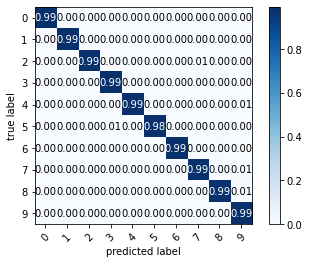

In [ ]:
# plotting confusion matrix using MLxtend library
fig, ax = plot_confusion_matrix(conf_mat=cm_mnist,
                                colorbar=True,
                                show_absolute=False,
                                show_normed=True,
                                class_names = [0,1,2,3,4,5,6,7,8,9])
plt.show()

In [ ]:
print(classification_report(y_test_mnist, prediction_mnist, target_names=['0','1','2','3','4','5','6','7','8','9']))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.99      0.99      0.99      1032
           3       0.99      0.99      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.98      0.99       892
           6       0.99      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.98      0.99      0.99       974
           9       0.98      0.99      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



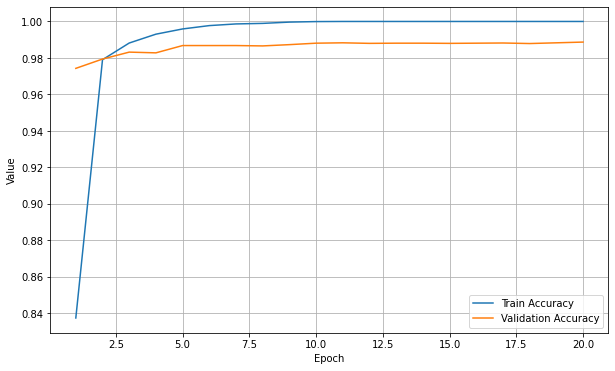

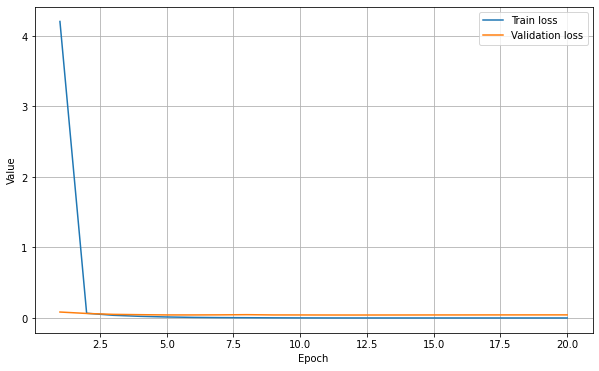

In [ ]:
# plotting learning curves using matplotlib
fig = plt.figure(figsize=(10, 6))
plot_graph(range(1, len(history_mnist.epoch)+1), history_mnist.history['sparse_categorical_accuracy'], label='Train Accuracy')
plot_graph(range(1, len(history_mnist.epoch)+1), history_mnist.history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
plt.legend()
plt.savefig(output_dir / "normal_model_Accuracy.png")

plt.figure(figsize=(10, 6))
plot_graph(range(1, len(history_mnist.epoch)+1), history_mnist.history['loss'], label='Train loss')
plot_graph(range(1, len(history_mnist.epoch)+1), history_mnist.history['val_loss'], label='Validation loss')
plt.legend()
plt.savefig(output_dir / "normal_model_loss_mnist.png")

## **Training the model on Federated data**

In [ ]:
def model_fn():
    # we must create a new model here, and not capture it from an external score.
    # TFF will call this within different graph contexts.

    keras_model = create_keras_model()
    keras_model.trainable = True,
    return tff.learning.from_keras_model(
        keras_model,
        input_spec = preprocessed_sample_dataset.element_spec,
        loss = tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]
    ) 

There are two optimizers in the Federated Averaging algorithm below: **client_optimizer_fn and server_optimizer_fn**. 

On each client, only local model changes are computed using the client_optimizer_fn.

The global model at the server is updated on average by the server_optimizer_fn.

In [ ]:
iterative_process = tff.learning.build_federated_averaging_process(
    model_fn,
    client_optimizer_fn=lambda: tf.keras.optimizers.Adam(learning_rate=client_lr),
    server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=server_lr))

Two federated computations have been built by TFF and are contained in a tff.templates file. These computations are available as two IterativeProcess attributes, initialise and next, in that process.

TFF aims to express computations in a manner that they might be carried out in actual federated learning environments, but at the moment only local execution simulation runtime is available. In a simulator, you just call a calculation like a Python function to have it run.

In [ ]:
print(str(iterative_process.initialize.type_signature.formatted_representation()))

( -> <
  model=<
    trainable=<
      float32[3,3,1,32],
      float32[32],
      float32[3,3,32,64],
      float32[64],
      float32[1600,512],
      float32[512],
      float32[512,10],
      float32[10]
    >,
    non_trainable=<>
  >,
  optimizer_state=<
    int64
  >,
  delta_aggregate_state=<>,
  model_broadcast_state=<>
>@SERVER)


You can tell that the server state is made up of a optimizer_state component, some empty parameters (such non_trainable, which controls server-to-client communication), and a model weights (the initial model parameters for MNIST that will be disseminated to all devices).

**Now that we have the server state constructed, let's run the initialise computation.**

In [ ]:
state = iterative_process.initialize()

tff_train_acc = []
tff_val_acc = []
tff_train_loss = []
tff_val_loss = []

In [ ]:
import os 
logs = "logs_mnist"
if not os.path.exists(logs):
    os.makedirs(logs)
for i in os.listdir(logs):
    os.remove(f'{logs}/{i}')

summary_writer = tf.summary.create_file_writer(logs)
state = iterative_process.initialize()

In particular, one should consider next() to be a declarative functional representation of the full decentralised computation rather than a server-based function. While each participating device contributes its own local dataset, some inputs (SERVER STATE) are provided by the server.

In [ ]:
with summary_writer.as_default():
    eval_model_mnist = None
    for round_num in range(1, NUM_ROUNDS+1):
        state, metrics = iterative_process.next(state, federated_train_data)
      
        print('round {:2d}, metrics={}'.format(round_num, metrics))
        
        # for name, value in metrics['client_work']['train'].items():
        name = ['sparse_categorical_accuracy', 'loss']

        for i in range(2):
            tf.summary.scalar(name[i], metrics[i], step=round_num)

        eval_model_mnist = create_keras_model()
        eval_model_mnist.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                       loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                       metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

        tff.learning.assign_weights_to_keras_model(eval_model_mnist, state.model)

        ev_result = eval_model_mnist.evaluate(x_test_mnist, y_test_mnist, verbose=0)
        print('round {:2d}, metrics={}'.format(round_num, metrics))
        print(f"Eval loss : {ev_result[0]} and Eval accuracy : {ev_result[1]}")
        tff_train_acc.append(float(metrics.sparse_categorical_accuracy))
        tff_val_acc.append(ev_result[1])
        tff_train_loss.append(float(metrics.loss))
        tff_val_loss.append(ev_result[0])


round  1, metrics=<sparse_categorical_accuracy=0.7642833590507507,loss=0.8666743636131287,keras_training_time_client_sum_sec=0.0>
round  1, metrics=<sparse_categorical_accuracy=0.7642833590507507,loss=0.8666743636131287,keras_training_time_client_sum_sec=0.0>
Eval loss : 1.8381858665466309 and Eval accuracy : 0.38359999656677246
round  2, metrics=<sparse_categorical_accuracy=0.9053633213043213,loss=0.3011506199836731,keras_training_time_client_sum_sec=0.0>
round  2, metrics=<sparse_categorical_accuracy=0.9053633213043213,loss=0.3011506199836731,keras_training_time_client_sum_sec=0.0>
Eval loss : 0.6759393375396728 and Eval accuracy : 0.8032000064849854
round  3, metrics=<sparse_categorical_accuracy=0.948033332824707,loss=0.17294995486736298,keras_training_time_client_sum_sec=0.0>
round  3, metrics=<sparse_categorical_accuracy=0.948033332824707,loss=0.17294995486736298,keras_training_time_client_sum_sec=0.0>
Eval loss : 0.16478824962563812 and Eval accuracy : 0.9502000212669373
round  4

After each round of federated training, the training loss is slowly decreasing, which shows the model is convergent.

## **Using TensorBoard to display model metrics**
Let's use Tensorboard to display the metrics from these federated computation.

In [ ]:
!ls {logs_mnist}
%tensorboard --logdir {logs} --port=0

[0.7642833590507507, 0.9053633213043213, 0.948033332824707, 0.9588133096694946, 0.9635966420173645, 0.9656866788864136, 0.9684100151062012, 0.9707000255584717, 0.9706100225448608, 0.9725900292396545, 0.9731199741363525, 0.9751200079917908, 0.9733499884605408, 0.9749000072479248, 0.9753433465957642, 0.974286675453186, 0.9753466844558716, 0.9753566384315491, 0.9753566384315491, 0.9749433398246765] [0.3836, 0.8032, 0.9502, 0.9555, 0.9664, 0.9662, 0.9693, 0.9686, 0.9684, 0.9681, 0.9688, 0.9699, 0.9684, 0.9689, 0.9718, 0.9699, 0.9719, 0.9708, 0.9713, 0.9681] [0.8666743636131287, 0.3011506199836731, 0.17294995486736298, 0.14609622955322266, 0.13335151970386505, 0.1315319687128067, 0.12108305841684341, 0.11568383872509003, 0.11574200540781021, 0.1101134866476059, 0.10577785223722458, 0.09842304140329361, 0.10555993765592575, 0.10190870612859726, 0.10184324532747269, 0.10535113513469696, 0.09926965087652206, 0.09948036819696426, 0.10086161643266678, 0.1051507517695427] [1.8381858665466309, 0.6

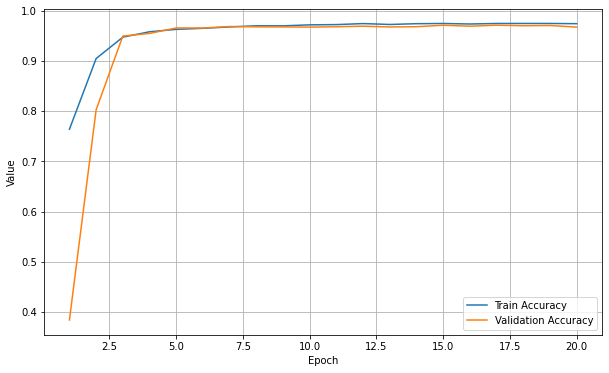

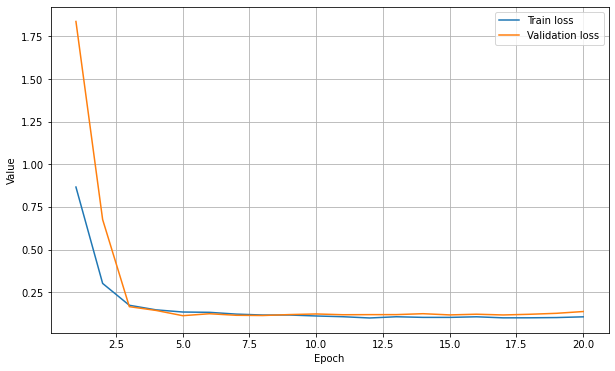

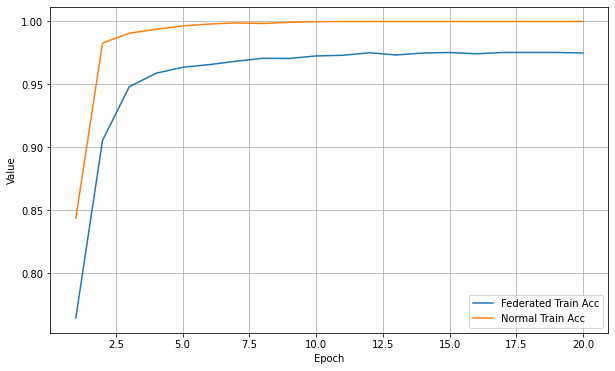

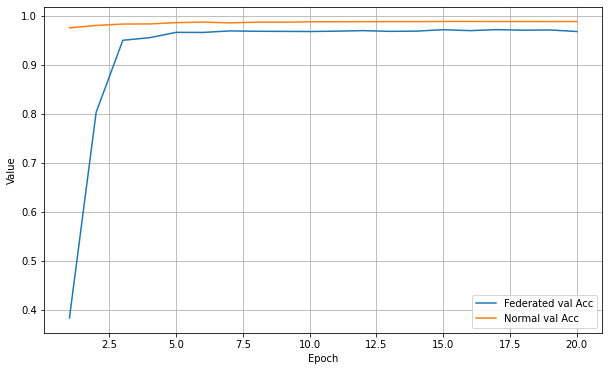

In [ ]:
output_mnist = "results_mnist"
if not os.path.exists(output_mnist):
    os.makedirs(output_mnist)
    
print(tff_train_acc, tff_val_acc, tff_train_loss, tff_val_loss)
fig = plt.figure(figsize=(10, 6))
plot_graph(list(range(1, len(tff_train_acc)+1)), tff_train_acc, label='Train Accuracy')
plot_graph(list(range(1, len(tff_val_acc)+1)), tff_val_acc, label='Validation Accuracy')
plt.legend()
plt.savefig(output_mnist+ "/federated_model_Accuracy_mnist.png")

plt.figure(figsize=(10, 6))
plot_graph(list(range(1, len(tff_train_acc)+1)), tff_train_loss, label='Train loss')
plot_graph(list(range(1, len(tff_train_acc)+1)), tff_val_loss, label='Validation loss')
plt.legend()
plt.savefig(output_mnist+ "/federated_model_loss_mnist.png")

plt.figure(figsize=(10, 6))
plot_graph(list(range(1, len(tff_train_acc)+1)), tff_train_acc, label='Federated Train Acc')
plot_graph(range(1, len(history_mnist.epoch)+1), history_mnist.history['sparse_categorical_accuracy'], label='Normal Train Acc')
plt.legend()
plt.savefig(output_mnist + "/federated_v_s_normal_model_train_Accuracy_mnist.png")

plt.figure(figsize=(10, 6))
plot_graph(list(range(1, len(tff_train_acc)+1)), tff_val_acc, label='Federated val Acc')
plot_graph(range(1, len(history_mnist.epoch)+1), history_mnist.history['val_sparse_categorical_accuracy'], label='Normal val Acc')
plt.legend()
plt.savefig(output_mnist+ "/federated_v_s_normal_model_validation_Accuracy_minst.png")

In [ ]:
fed_pred_mnist = eval_model_mnist.predict_classes(x_test_mnist)
fed_cm_mnist =  confusion_matrix(y_test_mnist, fed_pred_mnist)

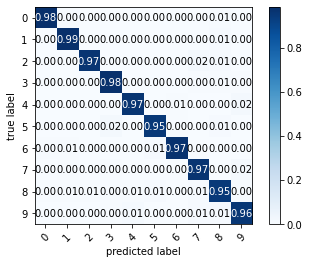

In [ ]:
fig, ax = plot_confusion_matrix(conf_mat=fed_cm_mnist,
                                colorbar=True,
                                show_absolute=False,
                                show_normed=True,
                                class_names = ['0','1','2','3','4','5','6','7','8','9'])
plt.show()

In [ ]:
print(classification_report(y_test_mnist, fed_pred_mnist, target_names=['0','1','2','3','4','5','6','7','8','9']))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       980
           1       0.98      0.99      0.98      1135
           2       0.98      0.97      0.97      1032
           3       0.96      0.98      0.97      1010
           4       0.97      0.97      0.97       982
           5       0.97      0.95      0.96       892
           6       0.98      0.97      0.98       958
           7       0.95      0.97      0.96      1028
           8       0.94      0.95      0.95       974
           9       0.95      0.96      0.95      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



## 3 Federated learning onf CIFAR-10 datasets

In [ ]:
client_lr = 1e-2
server_lr = 1
client_number = 20
NUM_ROUNDS = 20
NUM_EPOCHS = 5
BATCH_SIZE = 500
PREFETCH_BUFFER = 10
size_cifar = 32

In [ ]:
# creating model with keras 
def create_keras_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(size_cifar, size_cifar, 3)),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    return model

In [ ]:
# loading cifar model
(x_train_cifar, y_train_cifar), (x_test_cifar, y_test_cifar) = tf.keras.datasets.cifar10.load_data()

In [ ]:
x_train_cifar.shape

(50000, 32, 32, 3)

In [ ]:
x_train_cifar = x_train_cifar.astype(np.float32)
x_train_cifar = x_train_cifar.reshape(50000, size_cifar, size_cifar, 3)
y_train_cifar = y_train_cifar.astype(np.int32)
x_test_cifar = x_test_cifar.astype(np.float32).reshape(10000, size_cifar, size_cifar, 3)
y_test_cifar = y_test_cifar.astype(np.int32).reshape(10000, 1)

In [ ]:
x_train_cifar.shape

(50000, 32, 32, 3)

In [ ]:
total_image_count = len(x_train_cifar)
image_per_set = int(np.floor(total_image_count/client_number))

In [ ]:
print(image_per_set)

2500


In [ ]:
# preparing client train datasets
client_train_dataset_cifar = collections.OrderedDict()
for i in range(1, client_number+1):
    client_name = "client_" + str(i)
    start = image_per_set * (i-1)
    end = image_per_set * i

    print(f"Adding data from {start} to {end} for client : {client_name}")
    data = collections.OrderedDict((('label', y_train_cifar[start:end]), ('pixels', x_train_cifar[start:end])))
    client_train_dataset_cifar[client_name] = data

Adding data from 0 to 2500 for client : client_1
Adding data from 2500 to 5000 for client : client_2
Adding data from 5000 to 7500 for client : client_3
Adding data from 7500 to 10000 for client : client_4
Adding data from 10000 to 12500 for client : client_5
Adding data from 12500 to 15000 for client : client_6
Adding data from 15000 to 17500 for client : client_7
Adding data from 17500 to 20000 for client : client_8
Adding data from 20000 to 22500 for client : client_9
Adding data from 22500 to 25000 for client : client_10
Adding data from 25000 to 27500 for client : client_11
Adding data from 27500 to 30000 for client : client_12
Adding data from 30000 to 32500 for client : client_13
Adding data from 32500 to 35000 for client : client_14
Adding data from 35000 to 37500 for client : client_15
Adding data from 37500 to 40000 for client : client_16
Adding data from 40000 to 42500 for client : client_17
Adding data from 42500 to 45000 for client : client_18
Adding data from 45000 to 475

In [ ]:
train_dataset_cifar =  tff.simulation.FromTensorSlicesClientData(client_train_dataset_cifar)

In [ ]:
sample_dataset_cifar = train_dataset_cifar.create_tf_dataset_for_client(train_dataset_cifar.client_ids[0])
sample_element = next(iter(sample_dataset_cifar))

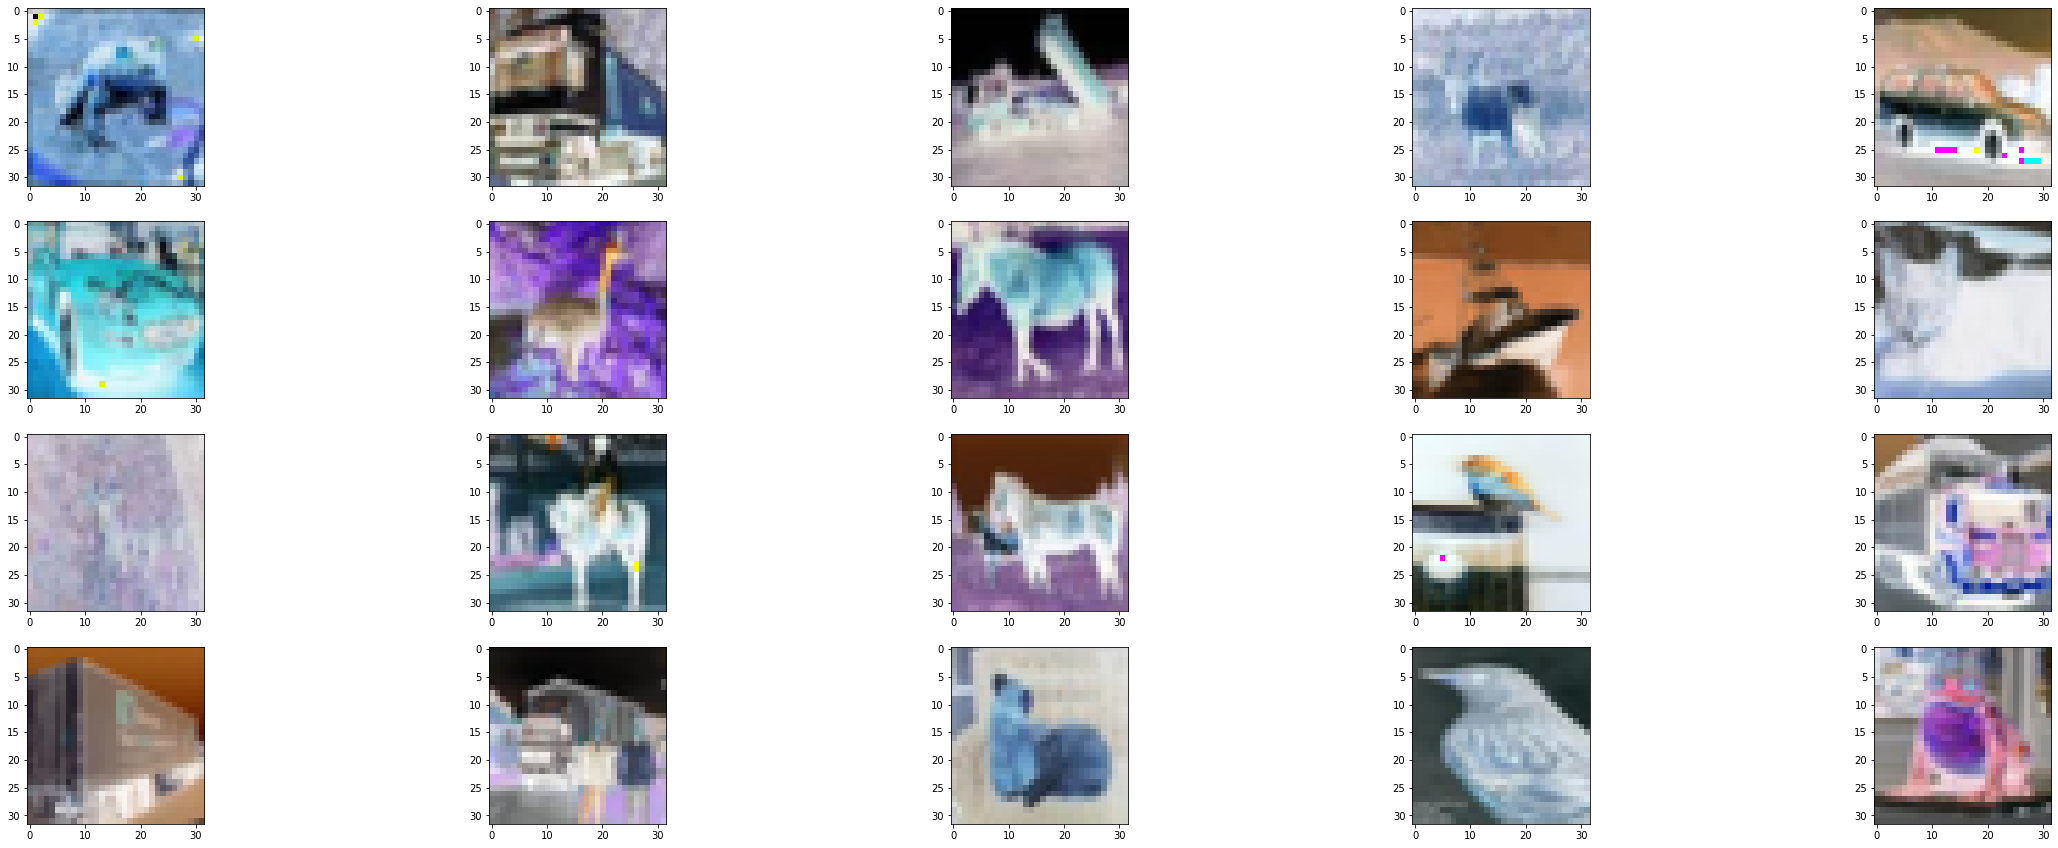

In [ ]:
# example of data for one client
figure = plt.figure(figsize=(40,15))
j = 0

for sample in sample_dataset_cifar.take(20):
    plt.subplot(4, 5, j+1)
    plt.imshow((sample['pixels'].numpy()*255).astype(np.uint8), aspect='equal')
    # plt.axis('off')
    j += 1

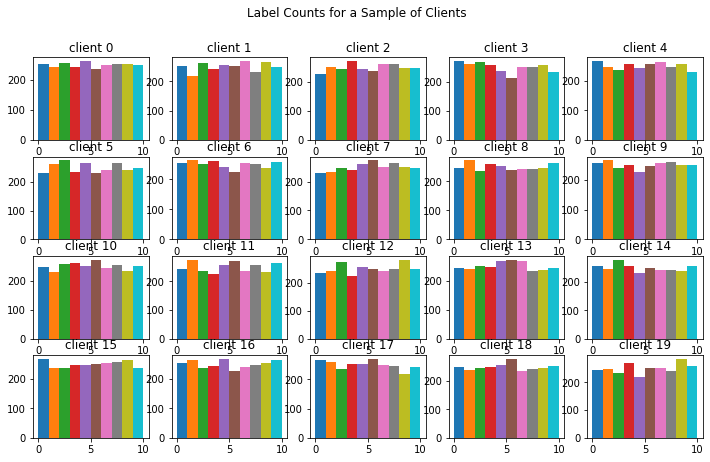

In [ ]:
# Number of examples per layer for a sample of clients 
f = plt.figure(figsize=(12, 7))
f.suptitle('Label Counts for a Sample of Clients')

for i in range(client_number):
    client_dataset = train_dataset_cifar.create_tf_dataset_for_client(
        train_dataset_cifar.client_ids[i]
    )

    plot_data = collections.defaultdict(list)


    for sample in client_dataset:
        label = sample['label'].numpy()[0]
        plot_data[label].append(label)
    
    plt.subplot(4, 5, i+1)
    plt.title(f'client {i}')
    for j in range(10):
        plt.hist(
            plot_data[j],
            density= False,
            bins = [0,1,2,3,4,5,6,7,8,9,10]
        )

In [ ]:
SHUFFLE_BUFFER = image_per_set
SHUFFLE_BUFFER

2500

In [ ]:
def preprocess(dataset):
    print(type(dataset))
    def batch_format_fn(element):        
        """Flatten a batch `pixels` and return the features as an `OrderedDict`."""
        return collections.OrderedDict(
            x = tf.reshape(element['pixels'], [-1, size_cifar, size_cifar, 3]),
            y = tf.reshape(element['label'], [-1, 1])
        )
    
    return dataset.repeat(NUM_EPOCHS).shuffle(SHUFFLE_BUFFER, seed = 1).batch(BATCH_SIZE).map(batch_format_fn).prefetch(PREFETCH_BUFFER)

In [ ]:
preprocessed_sample_dataset = preprocess(sample_dataset_cifar)
sample_batch = tf.nest.map_structure(lambda x: x.numpy(), next(iter(preprocessed_sample_dataset)))

<class 'tensorflow.python.data.ops.dataset_ops.TensorSliceDataset'>


In [ ]:
def make_federated_data(client_data, client_ids):
    return [preprocess(client_data.create_tf_dataset_for_client(x)) for x in client_ids]

In [ ]:
federated_train_data = make_federated_data(train_dataset_cifar, train_dataset_cifar.client_ids)

<class 'tensorflow.python.data.ops.dataset_ops.TensorSliceDataset'>
<class 'tensorflow.python.data.ops.dataset_ops.TensorSliceDataset'>
<class 'tensorflow.python.data.ops.dataset_ops.TensorSliceDataset'>
<class 'tensorflow.python.data.ops.dataset_ops.TensorSliceDataset'>
<class 'tensorflow.python.data.ops.dataset_ops.TensorSliceDataset'>
<class 'tensorflow.python.data.ops.dataset_ops.TensorSliceDataset'>
<class 'tensorflow.python.data.ops.dataset_ops.TensorSliceDataset'>
<class 'tensorflow.python.data.ops.dataset_ops.TensorSliceDataset'>
<class 'tensorflow.python.data.ops.dataset_ops.TensorSliceDataset'>
<class 'tensorflow.python.data.ops.dataset_ops.TensorSliceDataset'>
<class 'tensorflow.python.data.ops.dataset_ops.TensorSliceDataset'>
<class 'tensorflow.python.data.ops.dataset_ops.TensorSliceDataset'>
<class 'tensorflow.python.data.ops.dataset_ops.TensorSliceDataset'>
<class 'tensorflow.python.data.ops.dataset_ops.TensorSliceDataset'>
<class 'tensorflow.python.data.ops.dataset_ops.T

In [ ]:
print('Number of client datasets: {l}'.format(l=len(federated_train_data)))
print('First dataset: {d}'.format(d=federated_train_data[0]))

Number of client datasets: 20
First dataset: <PrefetchDataset shapes: OrderedDict([(x, (None, 32, 32, 3)), (y, (None, 1))]), types: OrderedDict([(x, tf.float32), (y, tf.int32)])>


In [ ]:
normal_model_cifar = create_keras_model()
normal_model_cifar.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

history_cifar = normal_model_cifar.fit(x_train_cifar, y_train_cifar, batch_size=BATCH_SIZE, epochs=20, validation_data=(x_test_cifar, y_test_cifar))
# normal_model.save(model_dir / "without_tff_model.h5")

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 16s 325us/sample - loss: 8.1403 - sparse_categorical_accuracy: 0.2354 - val_loss: 3.7589 - val_sparse_categorical_accuracy: 0.3242
Epoch 2/20
50000/50000 [==============================] - 17s 342us/sample - loss: 3.2289 - sparse_categorical_accuracy: 0.3548 - val_loss: 2.8028 - val_sparse_categorical_accuracy: 0.3778
Epoch 3/20
50000/50000 [==============================] - 16s 328us/sample - loss: 2.4830 - sparse_categorical_accuracy: 0.4147 - val_loss: 2.4161 - val_sparse_categorical_accuracy: 0.4203
Epoch 4/20
50000/50000 [==============================] - 16s 321us/sample - loss: 2.1229 - sparse_categorical_accuracy: 0.4516 - val_loss: 2.1797 - val_sparse_categorical_accuracy: 0.4434
Epoch 5/20
50000/50000 [==============================] - 18s 357us/sample - loss: 1.8704 - sparse_categorical_accuracy: 0.4849 - val_loss: 1.9666 - val_sparse_categorical_accuracy: 0.4659
Epoch

In [ ]:
prediction_cifar = normal_model_cifar.predict_classes(x_test_cifar)

In [ ]:
cm_cifar = confusion_matrix(y_test_cifar, prediction_cifar)

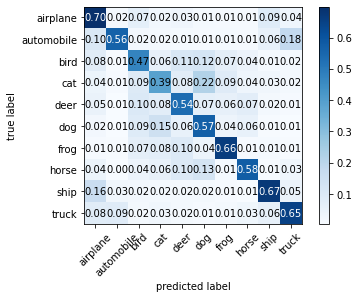

In [ ]:
fig, ax = plot_confusion_matrix(conf_mat=cm_cifar,
                                colorbar=True,
                                show_absolute=False,
                                show_normed=True,
                                class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck'])
plt.show()

In [ ]:
print(classification_report(y_test_cifar, prediction_cifar, target_names=['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']))

              precision    recall  f1-score   support

    airplane       0.54      0.70      0.61      1000
  automobile       0.77      0.56      0.65      1000
        bird       0.47      0.47      0.47      1000
         cat       0.44      0.39      0.41      1000
        deer       0.51      0.54      0.52      1000
         dog       0.48      0.57      0.52      1000
        frog       0.68      0.66      0.67      1000
       horse       0.68      0.58      0.62      1000
        ship       0.69      0.67      0.68      1000
       truck       0.64      0.65      0.65      1000

    accuracy                           0.58     10000
   macro avg       0.59      0.58      0.58     10000
weighted avg       0.59      0.58      0.58     10000



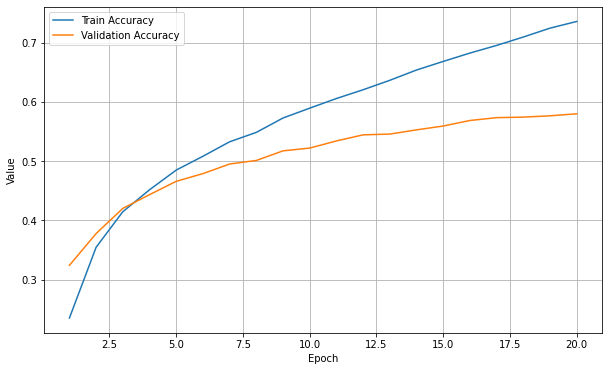

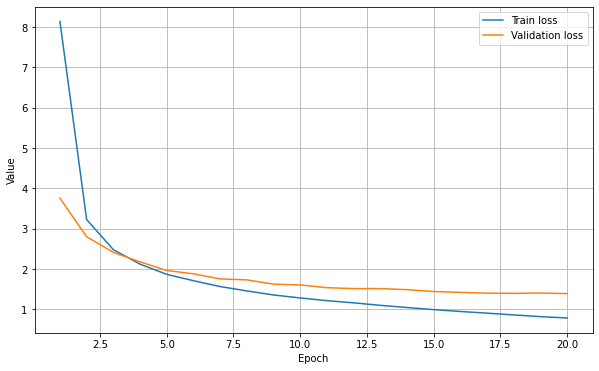

In [ ]:
fig = plt.figure(figsize=(10, 6))
plot_graph(range(1, len(history_cifar.epoch)+1), history_cifar.history['sparse_categorical_accuracy'], label='Train Accuracy')
plot_graph(range(1, len(history_cifar.epoch)+1), history_cifar.history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
plt.legend()
plt.savefig('results_cifar'+ "/normal_model_cifar_Accuracy.png")

plt.figure(figsize=(10, 6))
plot_graph(range(1, len(history_cifar.epoch)+1), history_cifar.history['loss'], label='Train loss')
plot_graph(range(1, len(history_cifar.epoch)+1), history_cifar.history['val_loss'], label='Validation loss')
plt.legend()
plt.savefig('results_cifar'+ "/normal_model_cifar_loss.png")


In [ ]:
def model_fn():
    # we must create a new model here, and not capture it from an external score.
    # TFF will call this within different graph contexts.

    keras_model = create_keras_model()
    # keras_model.trainable = True,
    return tff.learning.from_keras_model(
        keras_model,
        input_spec = preprocessed_sample_dataset.element_spec,
        loss = tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]
    ) 

In [ ]:
iterative_process = tff.learning.build_federated_averaging_process(
    model_fn,
    client_optimizer_fn=lambda: tf.keras.optimizers.Adam(learning_rate=client_lr),
    server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=server_lr))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [ ]:
print(str(iterative_process.initialize.type_signature.formatted_representation()))

( -> <
  model=<
    trainable=<
      float32[3,3,3,32],
      float32[32],
      float32[3,3,32,64],
      float32[64],
      float32[2304,512],
      float32[512],
      float32[512,10],
      float32[10]
    >,
    non_trainable=<>
  >,
  optimizer_state=<
    int64
  >,
  delta_aggregate_state=<>,
  model_broadcast_state=<>
>@SERVER)


In [ ]:
state = iterative_process.initialize()

tff_train_acc = []
tff_val_acc = []
tff_train_loss = []
tff_val_loss = []

In [ ]:
import os 
logs = "logs_cifar"
if not os.path.exists(logs):
    os.makedirs(logs)
for i in os.listdir(logs):
    os.remove(f'{logs}/{i}')

summary_writer = tf.summary.create_file_writer(logs)
state = iterative_process.initialize()

In [ ]:
with summary_writer.as_default():
    eval_model_cifar = None
    for round_num in range(1, NUM_ROUNDS+1):
        state, metrics = iterative_process.next(state, federated_train_data)
      
        print('round {:2d}, metrics={}'.format(round_num, metrics))
        
        # for name, value in metrics['client_work']['train'].items():
        name = ['sparse_categorical_accuracy', 'loss']

        for i in range(2):
            tf.summary.scalar(name[i], metrics[i], step=round_num)

        eval_model_cifar = create_keras_model()
        eval_model_cifar.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                       loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                       metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

        tff.learning.assign_weights_to_keras_model(eval_model_cifar, state.model)

        ev_result = eval_model_cifar.evaluate(x_test_cifar, y_test_cifar, verbose=0)
        print('round {:2d}, metrics={}'.format(round_num, metrics))
        print(f"Eval loss : {ev_result[0]} and Eval accuracy : {ev_result[1]}")
        tff_train_acc.append(float(metrics.sparse_categorical_accuracy))
        tff_val_acc.append(ev_result[1])
        tff_train_loss.append(float(metrics.loss))
        tff_val_loss.append(ev_result[0])


ERROR:asyncio:Task was destroyed but it is pending!
task: <Task pending coro=<trace.<locals>.async_trace() running at /home/jitu-fx516/anaconda3/envs/fed36/lib/python3.6/site-packages/tensorflow_federated/python/common_libs/tracing.py:281> wait_for=<Future pending cb=[_chain_future.<locals>._call_check_cancel() at /home/jitu-fx516/anaconda3/envs/fed36/lib/python3.6/asyncio/futures.py:403, Task._wakeup()]> cb=[Task._wakeup(), <1 more>, Task._wakeup()]>


round  1, metrics=<sparse_categorical_accuracy=0.533195972442627,loss=1.416908860206604,keras_training_time_client_sum_sec=0.0>
round  1, metrics=<sparse_categorical_accuracy=0.533195972442627,loss=1.416908860206604,keras_training_time_client_sum_sec=0.0>
Eval loss : 1.7731451183319091 and Eval accuracy : 0.373199999332428
round  2, metrics=<sparse_categorical_accuracy=0.6065359711647034,loss=1.1739925146102905,keras_training_time_client_sum_sec=0.0>
round  2, metrics=<sparse_categorical_accuracy=0.6065359711647034,loss=1.1739925146102905,keras_training_time_client_sum_sec=0.0>
Eval loss : 1.6887680034637451 and Eval accuracy : 0.41670000553131104
round  3, metrics=<sparse_categorical_accuracy=0.5809919834136963,loss=1.2938834428787231,keras_training_time_client_sum_sec=0.0>
round  3, metrics=<sparse_categorical_accuracy=0.5809919834136963,loss=1.2938834428787231,keras_training_time_client_sum_sec=0.0>
Eval loss : 1.742454126739502 and Eval accuracy : 0.3840000033378601
round  4, metri

: 

: 

In [ ]:
!ls {logs_cifar}
%tensorboard --logdir {logs} --port=0

[0.12075600028038025, 0.13885200023651123, 0.24039599299430847, 0.38970398902893066, 0.39392000436782837, 0.42622798681259155, 0.49108800292015076, 0.5617960095405579, 0.5618280172348022, 0.610044002532959, 0.608680009841919, 0.5703120231628418, 0.6014879941940308, 0.6392880082130432, 0.6731719970703125, 0.6349560022354126, 0.6919280290603638, 0.6386880278587341, 0.6972240209579468, 0.6930919885635376] [0.1, 0.1012, 0.2055, 0.3051, 0.3087, 0.3314, 0.3614, 0.4019, 0.3834, 0.4212, 0.4144, 0.3894, 0.4356, 0.4266, 0.4508, 0.4264, 0.4507, 0.4313, 0.4549, 0.4517] [4.900520324707031, 2.2545249462127686, 2.0810134410858154, 1.7230827808380127, 1.8020832538604736, 1.6695935726165771, 1.4960010051727295, 1.2923030853271484, 1.3346550464630127, 1.1654915809631348, 1.1971632242202759, 1.3358979225158691, 1.2105488777160645, 1.1082744598388672, 0.9906747937202454, 1.1414159536361694, 0.9436463713645935, 1.1480258703231812, 0.9153197407722473, 0.969683051109314] [2.3027909130096433, 2.30274312057495

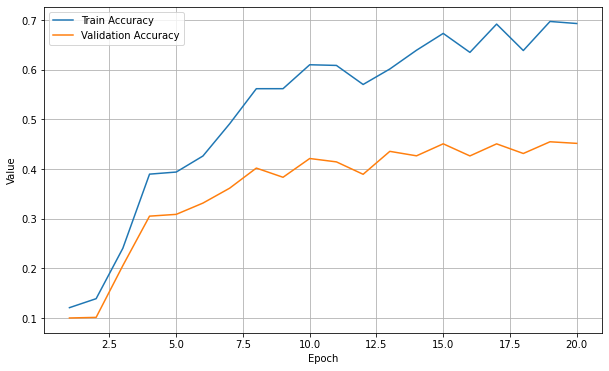

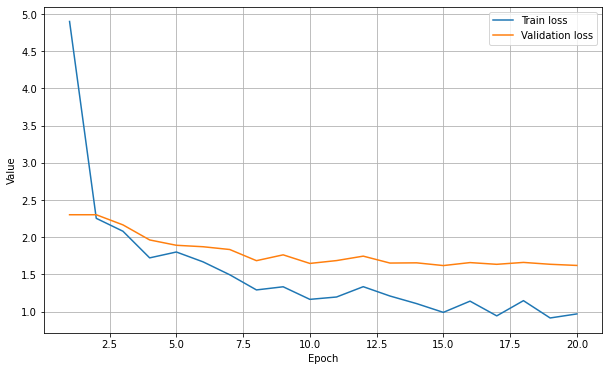

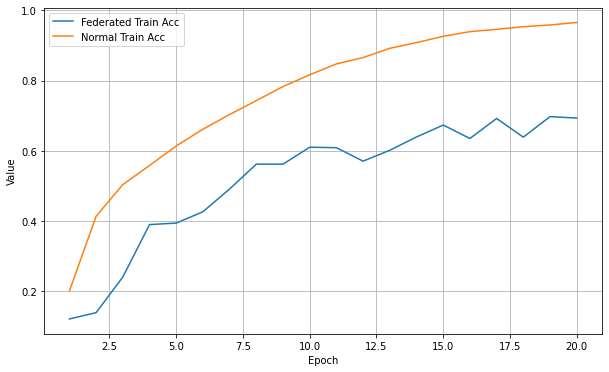

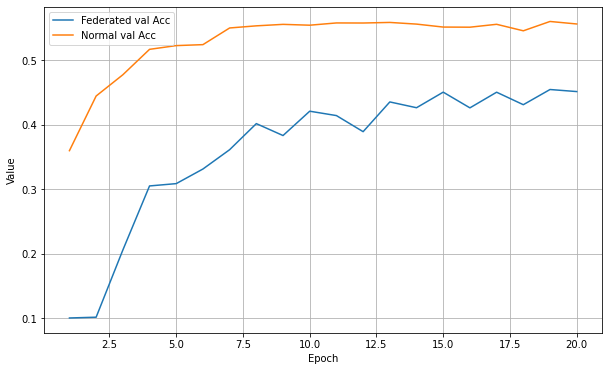

In [ ]:
print(tff_train_acc, tff_val_acc, tff_train_loss, tff_val_loss)
fig = plt.figure(figsize=(10, 6))
plot_graph(list(range(1, len(tff_train_acc)+1)), tff_train_acc, label='Train Accuracy')
plot_graph(list(range(1, len(tff_val_acc)+1)), tff_val_acc, label='Validation Accuracy')
plt.legend()
plt.savefig("results_cifar"+ "/federated_model_Accuracy.png")

plt.figure(figsize=(10, 6))
plot_graph(list(range(1, len(tff_train_acc)+1)), tff_train_loss, label='Train loss')
plot_graph(list(range(1, len(tff_train_acc)+1)), tff_val_loss, label='Validation loss')
plt.legend()
plt.savefig("results_cifar"+ "/federated_model_loss.png")

plt.figure(figsize=(10, 6))
plot_graph(list(range(1, len(tff_train_acc)+1)), tff_train_acc, label='Federated Train Acc')
plot_graph(range(1, len(history_cifar.epoch)+1), history_cifar.history['sparse_categorical_accuracy'], label='Normal Train Acc')
plt.legend()
plt.savefig("results_cifar"+ "/federated_v_s_normal_model_train_Accuracy.png")

plt.figure(figsize=(10, 6))
plot_graph(list(range(1, len(tff_train_acc)+1)), tff_val_acc, label='Federated val Acc')
plot_graph(range(1, len(history_cifar.epoch)+1), history_cifar.history['val_sparse_categorical_accuracy'], label='Normal val Acc')
plt.legend()
plt.savefig("results_cifar"+ "/federated_v_s_normal_model_validation_Accuracy.png")

In [ ]:
fed_pred_cifar = eval_model_cifar.predict_classes(x_test_cifar)
fed_cm_cifar =  confusion_matrix(y_test_cifar, fed_pred_cifar)

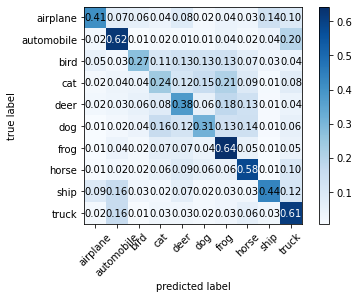

In [ ]:
fig, ax = plot_confusion_matrix(conf_mat=fed_cm_cifar,
                                colorbar=True,
                                show_absolute=False,
                                show_normed=True,
                                class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck'])
plt.show()

In [ ]:
print(classification_report(y_test_cifar, fed_pred_cifar, target_names=['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']))

              precision    recall  f1-score   support

    airplane       0.62      0.41      0.49      1000
  automobile       0.52      0.62      0.57      1000
        bird       0.49      0.27      0.35      1000
         cat       0.29      0.24      0.26      1000
        deer       0.35      0.38      0.36      1000
         dog       0.38      0.31      0.34      1000
        frog       0.43      0.64      0.52      1000
       horse       0.48      0.58      0.52      1000
        ship       0.60      0.44      0.50      1000
       truck       0.44      0.61      0.51      1000

    accuracy                           0.45     10000
   macro avg       0.46      0.45      0.44     10000
weighted avg       0.46      0.45      0.44     10000

